# Adversarial Attack

In [1]:
from auxiliar_code import *

Using TensorFlow backend.


### Load and show Images

In [11]:
original_image = load_image("broccoli.jpg")
hacked_image = load_image("hacked_broccoli_inception.png")

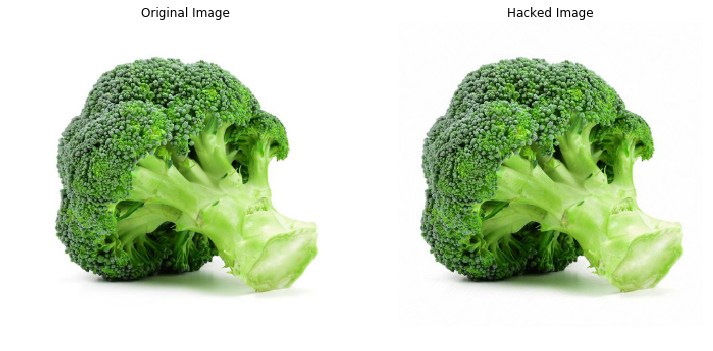

In [12]:
plot_images_contrast(original_image, hacked_image)

### Load Inception Neural Network

In [13]:
nn = load_neural_network("inception")

### Predict

In [14]:
predict(nn, original_image)

broccoli


In [15]:
predict(nn, hacked_image)

pizza


### Explanation

#### Class to attack

In [3]:
target_class = 963 # Pizza Class
# Classes: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

#### Gradients and Loss Function

In [6]:
im = preprocess_image(original_image)

inp_layer = nn.layers[0].input # Image
out_layer = nn.layers[-1].output # Probabilities

loss = out_layer[0, target_class]
grad = K.gradients(loss, inp_layer)[0]
optimize_gradient = K.function([inp_layer, K.learning_phase()], [grad, loss])

#### Create the Adversarial Image

In [7]:
%%time
certainty = 0.0

# Adv image should be similar to the original
max_pert = im + 0.01
min_pert = im - 0.01

adv = np.copy(im)

images = []

while certainty < 0.95:
    gr, certainty = optimize_gradient([adv, 0])
    adv += gr
    adv = np.clip(adv, min_pert, max_pert)
    adv = np.clip(adv, -1 , 1)
    images.append(denormalise(np.copy(im))-denormalise(np.copy(adv)))
    print("Certainty Degree", certainty)

Certainty Degree 2.4462338e-07
Certainty Degree 2.4463012e-07
Certainty Degree 2.446404e-07
Certainty Degree 2.4464762e-07
Certainty Degree 2.4465535e-07
Certainty Degree 2.4466556e-07
Certainty Degree 2.4467303e-07
Certainty Degree 2.4468162e-07
Certainty Degree 2.4469074e-07
Certainty Degree 2.4469796e-07
Certainty Degree 2.447073e-07
Certainty Degree 2.4471478e-07
Certainty Degree 2.4472342e-07
Certainty Degree 2.447297e-07
Certainty Degree 2.4474042e-07
Certainty Degree 2.4474838e-07
Certainty Degree 2.4475796e-07
Certainty Degree 2.4476518e-07
Certainty Degree 2.4477356e-07
Certainty Degree 2.4478243e-07
Certainty Degree 2.4479016e-07
Certainty Degree 2.447988e-07
Certainty Degree 2.4480693e-07
Certainty Degree 2.448151e-07
Certainty Degree 2.448233e-07
Certainty Degree 2.448324e-07
Certainty Degree 2.448401e-07
Certainty Degree 2.4484922e-07
Certainty Degree 2.448576e-07
Certainty Degree 2.448653e-07
Certainty Degree 2.4487485e-07
Certainty Degree 2.4488256e-07
Certainty Degree 2

Certainty Degree 2.4690684e-07
Certainty Degree 2.4691388e-07
Certainty Degree 2.4692307e-07
Certainty Degree 2.4693125e-07
Certainty Degree 2.4693927e-07
Certainty Degree 2.4694938e-07
Certainty Degree 2.469581e-07
Certainty Degree 2.4696658e-07
Certainty Degree 2.4697576e-07
Certainty Degree 2.46984e-07
Certainty Degree 2.4699273e-07
Certainty Degree 2.4700213e-07
Certainty Degree 2.470099e-07
Certainty Degree 2.470184e-07
Certainty Degree 2.4702663e-07
Certainty Degree 2.4703442e-07
Certainty Degree 2.470436e-07
Certainty Degree 2.4705233e-07
Certainty Degree 2.4706222e-07
Certainty Degree 2.4707e-07
Certainty Degree 2.4707845e-07
Certainty Degree 2.47086e-07
Certainty Degree 2.4709638e-07
Certainty Degree 2.471044e-07
Certainty Degree 2.471124e-07
Certainty Degree 2.4712278e-07
Certainty Degree 2.4713057e-07
Certainty Degree 2.471386e-07
Certainty Degree 2.4714961e-07
Certainty Degree 2.4715666e-07
Certainty Degree 2.4716564e-07
Certainty Degree 2.4717437e-07
Certainty Degree 2.471

Certainty Degree 2.4927297e-07
Certainty Degree 2.4928227e-07
Certainty Degree 2.4929176e-07
Certainty Degree 2.4930034e-07
Certainty Degree 2.493079e-07
Certainty Degree 2.4931762e-07
Certainty Degree 2.4932595e-07
Certainty Degree 2.4933524e-07
Certainty Degree 2.493438e-07
Certainty Degree 2.493538e-07
Certainty Degree 2.4936213e-07
Certainty Degree 2.4937094e-07
Certainty Degree 2.493795e-07
Certainty Degree 2.4938922e-07
Certainty Degree 2.4939874e-07
Certainty Degree 2.4940707e-07
Certainty Degree 2.4941562e-07
Certainty Degree 2.4942466e-07
Certainty Degree 2.494349e-07
Certainty Degree 2.494437e-07
Certainty Degree 2.494511e-07
Certainty Degree 2.494613e-07
Certainty Degree 2.494694e-07
Certainty Degree 2.4947818e-07
Certainty Degree 2.4948793e-07
Certainty Degree 2.4949745e-07
Certainty Degree 2.4950626e-07
Certainty Degree 2.4951385e-07
Certainty Degree 2.495236e-07
Certainty Degree 2.4953235e-07
Certainty Degree 2.4954068e-07
Certainty Degree 2.495502e-07
Certainty Degree 2.

Certainty Degree 2.5171502e-07
Certainty Degree 2.5172557e-07
Certainty Degree 2.5173443e-07
Certainty Degree 2.5174285e-07
Certainty Degree 2.5175268e-07
Certainty Degree 2.5176183e-07
Certainty Degree 2.5177118e-07
Certainty Degree 2.517808e-07
Certainty Degree 2.5178943e-07
Certainty Degree 2.5179955e-07
Certainty Degree 2.5180913e-07
Certainty Degree 2.5181848e-07
Certainty Degree 2.5182666e-07
Certainty Degree 2.5183743e-07
Certainty Degree 2.5184465e-07
Certainty Degree 2.5185523e-07
Certainty Degree 2.5186387e-07
Certainty Degree 2.5187322e-07
Certainty Degree 2.5188208e-07
Certainty Degree 2.5189098e-07
Certainty Degree 2.5190081e-07
Certainty Degree 2.519097e-07
Certainty Degree 2.5191932e-07
Certainty Degree 2.5192918e-07
Certainty Degree 2.519376e-07
Certainty Degree 2.5194694e-07
Certainty Degree 2.5195655e-07
Certainty Degree 2.519664e-07
Certainty Degree 2.5197505e-07
Certainty Degree 2.5198324e-07
Certainty Degree 2.5199407e-07
Certainty Degree 2.5200296e-07
Certainty De

Certainty Degree 2.5426144e-07
Certainty Degree 2.5427016e-07
Certainty Degree 2.5427815e-07
Certainty Degree 2.5428903e-07
Certainty Degree 2.5429753e-07
Certainty Degree 2.5430725e-07
Certainty Degree 2.5431765e-07
Certainty Degree 2.5432757e-07
Certainty Degree 2.5433633e-07
Certainty Degree 2.543453e-07
Certainty Degree 2.5435477e-07
Certainty Degree 2.543635e-07
Certainty Degree 2.5437225e-07
Certainty Degree 2.5438388e-07
Certainty Degree 2.543909e-07
Certainty Degree 2.5440158e-07
Certainty Degree 2.5441005e-07
Certainty Degree 2.5442048e-07
Certainty Degree 2.5443092e-07
Certainty Degree 2.5444112e-07
Certainty Degree 2.544501e-07
Certainty Degree 2.5445954e-07
Certainty Degree 2.5446874e-07
Certainty Degree 2.5447895e-07
Certainty Degree 2.5448767e-07
Certainty Degree 2.5449592e-07
Certainty Degree 2.5450515e-07
Certainty Degree 2.5451487e-07
Certainty Degree 2.5452405e-07
Certainty Degree 2.5453403e-07
Certainty Degree 2.5454446e-07
Certainty Degree 2.545532e-07
Certainty Deg

Certainty Degree 2.5684713e-07
Certainty Degree 2.568569e-07
Certainty Degree 2.5686572e-07
Certainty Degree 2.5687572e-07
Certainty Degree 2.5688527e-07
Certainty Degree 2.5689633e-07
Certainty Degree 2.569066e-07
Certainty Degree 2.5691543e-07
Certainty Degree 2.5692623e-07
Certainty Degree 2.5693575e-07
Certainty Degree 2.5694456e-07
Certainty Degree 2.5695488e-07
Certainty Degree 2.5696443e-07
Certainty Degree 2.569735e-07
Certainty Degree 2.5698455e-07
Certainty Degree 2.5699313e-07
Certainty Degree 2.570024e-07
Certainty Degree 2.5701124e-07
Certainty Degree 2.5702275e-07
Certainty Degree 2.5703204e-07
Certainty Degree 2.5704185e-07
Certainty Degree 2.570514e-07
Certainty Degree 2.5705927e-07
Certainty Degree 2.570693e-07
Certainty Degree 2.5708033e-07
Certainty Degree 2.5708866e-07
Certainty Degree 2.5709969e-07
Certainty Degree 2.5710827e-07
Certainty Degree 2.571171e-07
Certainty Degree 2.5712617e-07
Certainty Degree 2.5713717e-07
Certainty Degree 2.5714527e-07
Certainty Degre

Certainty Degree 2.5946818e-07
Certainty Degree 2.5947708e-07
Certainty Degree 2.5948722e-07
Certainty Degree 2.5949686e-07
Certainty Degree 2.5950752e-07
Certainty Degree 2.5951766e-07
Certainty Degree 2.5952656e-07
Certainty Degree 2.5953622e-07
Certainty Degree 2.5954662e-07
Certainty Degree 2.5955626e-07
Certainty Degree 2.5956663e-07
Certainty Degree 2.5957678e-07
Certainty Degree 2.5958522e-07
Certainty Degree 2.5959608e-07
Certainty Degree 2.5960625e-07
Certainty Degree 2.596144e-07
Certainty Degree 2.596253e-07
Certainty Degree 2.5963442e-07
Certainty Degree 2.5964334e-07
Certainty Degree 2.5965426e-07
Certainty Degree 2.5966366e-07
Certainty Degree 2.5967307e-07
Certainty Degree 2.5968296e-07
Certainty Degree 2.596943e-07
Certainty Degree 2.59703e-07
Certainty Degree 2.5971366e-07
Certainty Degree 2.5972432e-07
Certainty Degree 2.5973347e-07
Certainty Degree 2.5974214e-07
Certainty Degree 2.5975257e-07
Certainty Degree 2.5976146e-07
Certainty Degree 2.597721e-07
Certainty Degr

Certainty Degree 2.6213525e-07
Certainty Degree 2.6214624e-07
Certainty Degree 2.6215648e-07
Certainty Degree 2.6216546e-07
Certainty Degree 2.621752e-07
Certainty Degree 2.6218396e-07
Certainty Degree 2.6219374e-07
Certainty Degree 2.6220374e-07
Certainty Degree 2.6221326e-07
Certainty Degree 2.6222477e-07
Certainty Degree 2.6223293e-07
Certainty Degree 2.622427e-07
Certainty Degree 2.6225396e-07
Certainty Degree 2.62265e-07
Certainty Degree 2.622755e-07
Certainty Degree 2.6228645e-07
Certainty Degree 2.6229446e-07
Certainty Degree 2.623052e-07
Certainty Degree 2.6231422e-07
Certainty Degree 2.623262e-07
Certainty Degree 2.62335e-07
Certainty Degree 2.62344e-07
Certainty Degree 2.6235475e-07
Certainty Degree 2.6236427e-07
Certainty Degree 2.6237478e-07
Certainty Degree 2.6238328e-07
Certainty Degree 2.623928e-07
Certainty Degree 2.6240406e-07
Certainty Degree 2.6241355e-07
Certainty Degree 2.6242284e-07
Certainty Degree 2.624323e-07
Certainty Degree 2.6244308e-07
Certainty Degree 2.62

Certainty Degree 2.6487143e-07
Certainty Degree 2.6488254e-07
Certainty Degree 2.6489187e-07
Certainty Degree 2.6490196e-07
Certainty Degree 2.6491256e-07
Certainty Degree 2.6492341e-07
Certainty Degree 2.649358e-07
Certainty Degree 2.6494413e-07
Certainty Degree 2.649545e-07
Certainty Degree 2.6496588e-07
Certainty Degree 2.6497574e-07
Certainty Degree 2.6498532e-07
Certainty Degree 2.6499492e-07
Certainty Degree 2.6500757e-07
Certainty Degree 2.650164e-07
Certainty Degree 2.6502678e-07
Certainty Degree 2.6503616e-07
Certainty Degree 2.65047e-07
Certainty Degree 2.650566e-07
Certainty Degree 2.6506748e-07
Certainty Degree 2.6507783e-07
Certainty Degree 2.6508692e-07
Certainty Degree 2.6509755e-07
Certainty Degree 2.651084e-07
Certainty Degree 2.651175e-07
Certainty Degree 2.6512862e-07
Certainty Degree 2.651382e-07
Certainty Degree 2.651496e-07
Certainty Degree 2.6515846e-07
Certainty Degree 2.651688e-07
Certainty Degree 2.6517966e-07
Certainty Degree 2.651905e-07
Certainty Degree 2.6

Certainty Degree 2.6766193e-07
Certainty Degree 2.676706e-07
Certainty Degree 2.6768132e-07
Certainty Degree 2.6769203e-07
Certainty Degree 2.6770275e-07
Certainty Degree 2.6771244e-07
Certainty Degree 2.6772443e-07
Certainty Degree 2.677344e-07
Certainty Degree 2.677469e-07
Certainty Degree 2.6775632e-07
Certainty Degree 2.6776524e-07
Certainty Degree 2.677765e-07
Certainty Degree 2.677885e-07
Certainty Degree 2.6779742e-07
Certainty Degree 2.6780893e-07
Certainty Degree 2.678176e-07
Certainty Degree 2.6782962e-07
Certainty Degree 2.6783727e-07
Certainty Degree 2.67848e-07
Certainty Degree 2.678595e-07
Certainty Degree 2.6786998e-07
Certainty Degree 2.6788092e-07
Certainty Degree 2.6789039e-07
Certainty Degree 2.6790215e-07
Certainty Degree 2.6791213e-07
Certainty Degree 2.6792233e-07
Certainty Degree 2.679333e-07
Certainty Degree 2.6794325e-07
Certainty Degree 2.6795374e-07
Certainty Degree 2.6796448e-07
Certainty Degree 2.679734e-07
Certainty Degree 2.6798568e-07
Certainty Degree 2.

Certainty Degree 2.7051553e-07
Certainty Degree 2.705261e-07
Certainty Degree 2.7053667e-07
Certainty Degree 2.7054878e-07
Certainty Degree 2.7055805e-07
Certainty Degree 2.7056916e-07
Certainty Degree 2.7058e-07
Certainty Degree 2.7059085e-07
Certainty Degree 2.7060037e-07
Certainty Degree 2.7061225e-07
Certainty Degree 2.7062333e-07
Certainty Degree 2.7063342e-07
Certainty Degree 2.706453e-07
Certainty Degree 2.706559e-07
Certainty Degree 2.7066594e-07
Certainty Degree 2.706765e-07
Certainty Degree 2.7068737e-07
Certainty Degree 2.7069999e-07
Certainty Degree 2.7070982e-07
Certainty Degree 2.707212e-07
Certainty Degree 2.7073094e-07
Certainty Degree 2.707415e-07
Certainty Degree 2.707511e-07
Certainty Degree 2.7076163e-07
Certainty Degree 2.7077274e-07
Certainty Degree 2.7078332e-07
Certainty Degree 2.7079494e-07
Certainty Degree 2.7080554e-07
Certainty Degree 2.708182e-07
Certainty Degree 2.7082825e-07
Certainty Degree 2.7083757e-07
Certainty Degree 2.7084943e-07
Certainty Degree 2.

Certainty Degree 2.7345328e-07
Certainty Degree 2.7346525e-07
Certainty Degree 2.7347542e-07
Certainty Degree 2.7348665e-07
Certainty Degree 2.7349813e-07
Certainty Degree 2.7350984e-07
Certainty Degree 2.7351948e-07
Certainty Degree 2.7353173e-07
Certainty Degree 2.7354218e-07
Certainty Degree 2.7355287e-07
Certainty Degree 2.735641e-07
Certainty Degree 2.7357743e-07
Certainty Degree 2.735847e-07
Certainty Degree 2.7359772e-07
Certainty Degree 2.7360892e-07
Certainty Degree 2.7362017e-07
Certainty Degree 2.7363086e-07
Certainty Degree 2.7364254e-07
Certainty Degree 2.7365405e-07
Certainty Degree 2.7366423e-07
Certainty Degree 2.7367545e-07
Certainty Degree 2.7368694e-07
Certainty Degree 2.7369634e-07
Certainty Degree 2.7370703e-07
Certainty Degree 2.7371905e-07
Certainty Degree 2.737313e-07
Certainty Degree 2.7374307e-07
Certainty Degree 2.737535e-07
Certainty Degree 2.7376396e-07
Certainty Degree 2.7377567e-07
Certainty Degree 2.7378692e-07
Certainty Degree 2.7379764e-07
Certainty De

Certainty Degree 2.7646905e-07
Certainty Degree 2.7647934e-07
Certainty Degree 2.7649202e-07
Certainty Degree 2.7650177e-07
Certainty Degree 2.765139e-07
Certainty Degree 2.765263e-07
Certainty Degree 2.7653655e-07
Certainty Degree 2.7654923e-07
Certainty Degree 2.7655793e-07
Certainty Degree 2.7657111e-07
Certainty Degree 2.7658194e-07
Certainty Degree 2.7659217e-07
Certainty Degree 2.7660377e-07
Certainty Degree 2.7661568e-07
Certainty Degree 2.7662728e-07
Certainty Degree 2.7663862e-07
Certainty Degree 2.766499e-07
Certainty Degree 2.76661e-07
Certainty Degree 2.7667264e-07
Certainty Degree 2.7668398e-07
Certainty Degree 2.7669583e-07
Certainty Degree 2.7670774e-07
Certainty Degree 2.7671877e-07
Certainty Degree 2.7673067e-07
Certainty Degree 2.7674199e-07
Certainty Degree 2.767536e-07
Certainty Degree 2.767639e-07
Certainty Degree 2.767752e-07
Certainty Degree 2.7678868e-07
Certainty Degree 2.7680002e-07
Certainty Degree 2.7681006e-07
Certainty Degree 2.7682194e-07
Certainty Degree

Certainty Degree 2.7956494e-07
Certainty Degree 2.7957694e-07
Certainty Degree 2.7958922e-07
Certainty Degree 2.7959987e-07
Certainty Degree 2.7961158e-07
Certainty Degree 2.7962332e-07
Certainty Degree 2.7963614e-07
Certainty Degree 2.7964816e-07
Certainty Degree 2.7965723e-07
Certainty Degree 2.7967107e-07
Certainty Degree 2.796828e-07
Certainty Degree 2.7969267e-07
Certainty Degree 2.7970574e-07
Certainty Degree 2.7971637e-07
Certainty Degree 2.7972706e-07
Certainty Degree 2.797388e-07
Certainty Degree 2.7975025e-07
Certainty Degree 2.7976202e-07
Certainty Degree 2.7977242e-07
Certainty Degree 2.7978572e-07
Certainty Degree 2.7979561e-07
Certainty Degree 2.7980843e-07
Certainty Degree 2.798207e-07
Certainty Degree 2.798314e-07
Certainty Degree 2.79842e-07
Certainty Degree 2.7985456e-07
Certainty Degree 2.7986658e-07
Certainty Degree 2.7987673e-07
Certainty Degree 2.79889e-07
Certainty Degree 2.799002e-07
Certainty Degree 2.7991223e-07
Certainty Degree 2.7992286e-07
Certainty Degree 

Certainty Degree 2.8276753e-07
Certainty Degree 2.8277938e-07
Certainty Degree 2.8279234e-07
Certainty Degree 2.8280257e-07
Certainty Degree 2.8281576e-07
Certainty Degree 2.8282682e-07
Certainty Degree 2.8283785e-07
Certainty Degree 2.828497e-07
Certainty Degree 2.8286186e-07
Certainty Degree 2.8287454e-07
Certainty Degree 2.828875e-07
Certainty Degree 2.8289884e-07
Certainty Degree 2.8291257e-07
Certainty Degree 2.829231e-07
Certainty Degree 2.8293496e-07
Certainty Degree 2.829466e-07
Certainty Degree 2.8295818e-07
Certainty Degree 2.8297137e-07
Certainty Degree 2.829835e-07
Certainty Degree 2.8299402e-07
Certainty Degree 2.830059e-07
Certainty Degree 2.8301915e-07
Certainty Degree 2.8303046e-07
Certainty Degree 2.8304342e-07
Certainty Degree 2.830534e-07
Certainty Degree 2.8306584e-07
Certainty Degree 2.8307855e-07
Certainty Degree 2.8309069e-07
Certainty Degree 2.8310276e-07
Certainty Degree 2.8311388e-07
Certainty Degree 2.8312627e-07
Certainty Degree 2.831379e-07
Certainty Degree

Certainty Degree 2.8603918e-07
Certainty Degree 2.8605146e-07
Certainty Degree 2.8606425e-07
Certainty Degree 2.860765e-07
Certainty Degree 2.8608906e-07
Certainty Degree 2.860989e-07
Certainty Degree 2.861125e-07
Certainty Degree 2.861248e-07
Certainty Degree 2.8613928e-07
Certainty Degree 2.8614937e-07
Certainty Degree 2.861622e-07
Certainty Degree 2.8617285e-07
Certainty Degree 2.8618595e-07
Certainty Degree 2.8619735e-07
Certainty Degree 2.862099e-07
Certainty Degree 2.8622276e-07
Certainty Degree 2.8623504e-07
Certainty Degree 2.8624646e-07
Certainty Degree 2.8625712e-07
Certainty Degree 2.8626994e-07
Certainty Degree 2.8628386e-07
Certainty Degree 2.8629697e-07
Certainty Degree 2.8630737e-07
Certainty Degree 2.8631965e-07
Certainty Degree 2.863333e-07
Certainty Degree 2.8634477e-07
Certainty Degree 2.8635702e-07
Certainty Degree 2.8636742e-07
Certainty Degree 2.8637967e-07
Certainty Degree 2.863917e-07
Certainty Degree 2.8640397e-07
Certainty Degree 2.8641517e-07
Certainty Degree

Certainty Degree 2.8935193e-07
Certainty Degree 2.8936378e-07
Certainty Degree 2.8937703e-07
Certainty Degree 2.8938808e-07
Certainty Degree 2.8940133e-07
Certainty Degree 2.894132e-07
Certainty Degree 2.8942506e-07
Certainty Degree 2.8943637e-07
Certainty Degree 2.894488e-07
Certainty Degree 2.894618e-07
Certainty Degree 2.8947392e-07
Certainty Degree 2.8948605e-07
Certainty Degree 2.8949987e-07
Certainty Degree 2.8951038e-07
Certainty Degree 2.895233e-07
Certainty Degree 2.8953545e-07
Certainty Degree 2.8954705e-07
Certainty Degree 2.8955975e-07
Certainty Degree 2.8957078e-07
Certainty Degree 2.895832e-07
Certainty Degree 2.8959673e-07
Certainty Degree 2.8961026e-07
Certainty Degree 2.896213e-07
Certainty Degree 2.8963512e-07
Certainty Degree 2.896472e-07
Certainty Degree 2.8965857e-07
Certainty Degree 2.8967128e-07
Certainty Degree 2.8968287e-07
Certainty Degree 2.8969504e-07
Certainty Degree 2.897077e-07
Certainty Degree 2.8972013e-07
Certainty Degree 2.897323e-07
Certainty Degree 

Certainty Degree 2.9272937e-07
Certainty Degree 2.927405e-07
Certainty Degree 2.9275475e-07
Certainty Degree 2.9276762e-07
Certainty Degree 2.9278104e-07
Certainty Degree 2.9279275e-07
Certainty Degree 2.928064e-07
Certainty Degree 2.928198e-07
Certainty Degree 2.9283154e-07
Certainty Degree 2.9284465e-07
Certainty Degree 2.9285778e-07
Certainty Degree 2.928706e-07
Certainty Degree 2.9288233e-07
Certainty Degree 2.9289632e-07
Certainty Degree 2.929089e-07
Certainty Degree 2.929223e-07
Certainty Degree 2.9293398e-07
Certainty Degree 2.9294654e-07
Certainty Degree 2.9296072e-07
Certainty Degree 2.9297192e-07
Certainty Degree 2.929862e-07
Certainty Degree 2.9299872e-07
Certainty Degree 2.9301103e-07
Certainty Degree 2.930233e-07
Certainty Degree 2.9303618e-07
Certainty Degree 2.9304957e-07
Certainty Degree 2.9306298e-07
Certainty Degree 2.9307472e-07
Certainty Degree 2.9308757e-07
Certainty Degree 2.9309896e-07
Certainty Degree 2.931127e-07
Certainty Degree 2.93125e-07
Certainty Degree 2.

Certainty Degree 2.9624692e-07
Certainty Degree 2.9626102e-07
Certainty Degree 2.9627432e-07
Certainty Degree 2.962876e-07
Certainty Degree 2.963011e-07
Certainty Degree 2.9631326e-07
Certainty Degree 2.963282e-07
Certainty Degree 2.9634066e-07
Certainty Degree 2.9635476e-07
Certainty Degree 2.9636834e-07
Certainty Degree 2.963819e-07
Certainty Degree 2.9639463e-07
Certainty Degree 2.9640736e-07
Certainty Degree 2.9642092e-07
Certainty Degree 2.964342e-07
Certainty Degree 2.964475e-07
Certainty Degree 2.964605e-07
Certainty Degree 2.9647407e-07
Certainty Degree 2.9648677e-07
Certainty Degree 2.964995e-07
Certainty Degree 2.9651417e-07
Certainty Degree 2.9652574e-07
Certainty Degree 2.9653958e-07
Certainty Degree 2.9655405e-07
Certainty Degree 2.965665e-07
Certainty Degree 2.9657892e-07
Certainty Degree 2.965936e-07
Certainty Degree 2.966055e-07
Certainty Degree 2.9661908e-07
Certainty Degree 2.9663153e-07
Certainty Degree 2.966454e-07
Certainty Degree 2.9665867e-07
Certainty Degree 2.9

Certainty Degree 2.998794e-07
Certainty Degree 2.9989454e-07
Certainty Degree 2.9990744e-07
Certainty Degree 2.9992117e-07
Certainty Degree 2.9993373e-07
Certainty Degree 2.9994803e-07
Certainty Degree 2.9996292e-07
Certainty Degree 2.999775e-07
Certainty Degree 2.999915e-07
Certainty Degree 3.000052e-07
Certainty Degree 3.0001976e-07
Certainty Degree 3.0003469e-07
Certainty Degree 3.0004554e-07
Certainty Degree 3.0006012e-07
Certainty Degree 3.000727e-07
Certainty Degree 3.0008673e-07
Certainty Degree 3.000996e-07
Certainty Degree 3.0011276e-07
Certainty Degree 3.0012677e-07
Certainty Degree 3.0014195e-07
Certainty Degree 3.0015426e-07
Certainty Degree 3.0016767e-07
Certainty Degree 3.0018114e-07
Certainty Degree 3.001966e-07
Certainty Degree 3.002101e-07
Certainty Degree 3.002241e-07
Certainty Degree 3.0023753e-07
Certainty Degree 3.0025186e-07
Certainty Degree 3.0026388e-07
Certainty Degree 3.002796e-07
Certainty Degree 3.0029366e-07
Certainty Degree 3.0030566e-07
Certainty Degree 3

Certainty Degree 3.0362332e-07
Certainty Degree 3.0363634e-07
Certainty Degree 3.0365078e-07
Certainty Degree 3.036647e-07
Certainty Degree 3.0367744e-07
Certainty Degree 3.0369137e-07
Certainty Degree 3.0370586e-07
Certainty Degree 3.0371945e-07
Certainty Degree 3.037336e-07
Certainty Degree 3.0374662e-07
Certainty Degree 3.037608e-07
Certainty Degree 3.0377385e-07
Certainty Degree 3.0378888e-07
Certainty Degree 3.0380218e-07
Certainty Degree 3.0381892e-07
Certainty Degree 3.0383168e-07
Certainty Degree 3.0384444e-07
Certainty Degree 3.0385834e-07
Certainty Degree 3.0387343e-07
Certainty Degree 3.0388617e-07
Certainty Degree 3.0390035e-07
Certainty Degree 3.0391573e-07
Certainty Degree 3.0392792e-07
Certainty Degree 3.0394094e-07
Certainty Degree 3.0395512e-07
Certainty Degree 3.0396845e-07
Certainty Degree 3.0398323e-07
Certainty Degree 3.0399713e-07
Certainty Degree 3.0401222e-07
Certainty Degree 3.040253e-07
Certainty Degree 3.0404235e-07
Certainty Degree 3.040545e-07
Certainty Deg

Certainty Degree 3.0743172e-07
Certainty Degree 3.0744786e-07
Certainty Degree 3.0746162e-07
Certainty Degree 3.0747657e-07
Certainty Degree 3.0749035e-07
Certainty Degree 3.0750562e-07
Certainty Degree 3.075176e-07
Certainty Degree 3.0753287e-07
Certainty Degree 3.0754754e-07
Certainty Degree 3.0756135e-07
Certainty Degree 3.0757627e-07
Certainty Degree 3.0759125e-07
Certainty Degree 3.076056e-07
Certainty Degree 3.0761998e-07
Certainty Degree 3.0763374e-07
Certainty Degree 3.0764812e-07
Certainty Degree 3.0766216e-07
Certainty Degree 3.0767683e-07
Certainty Degree 3.076903e-07
Certainty Degree 3.0770497e-07
Certainty Degree 3.0772023e-07
Certainty Degree 3.0773313e-07
Certainty Degree 3.0774723e-07
Certainty Degree 3.0776192e-07
Certainty Degree 3.077748e-07
Certainty Degree 3.077895e-07
Certainty Degree 3.0780535e-07
Certainty Degree 3.0782093e-07
Certainty Degree 3.07835e-07
Certainty Degree 3.078479e-07
Certainty Degree 3.0786285e-07
Certainty Degree 3.0787606e-07
Certainty Degree

Certainty Degree 3.1132325e-07
Certainty Degree 3.1134016e-07
Certainty Degree 3.1135352e-07
Certainty Degree 3.113699e-07
Certainty Degree 3.113841e-07
Certainty Degree 3.1139749e-07
Certainty Degree 3.1141195e-07
Certainty Degree 3.1142798e-07
Certainty Degree 3.1144197e-07
Certainty Degree 3.1145711e-07
Certainty Degree 3.1147073e-07
Certainty Degree 3.114853e-07
Certainty Degree 3.1149958e-07
Certainty Degree 3.115153e-07
Certainty Degree 3.1153164e-07
Certainty Degree 3.1154562e-07
Certainty Degree 3.1155838e-07
Certainty Degree 3.1157413e-07
Certainty Degree 3.1158837e-07
Certainty Degree 3.1160232e-07
Certainty Degree 3.1161687e-07
Certainty Degree 3.11632e-07
Certainty Degree 3.1164598e-07
Certainty Degree 3.1166113e-07
Certainty Degree 3.1167508e-07
Certainty Degree 3.1168938e-07
Certainty Degree 3.1170333e-07
Certainty Degree 3.1171817e-07
Certainty Degree 3.1173275e-07
Certainty Degree 3.1174764e-07
Certainty Degree 3.117631e-07
Certainty Degree 3.1177885e-07
Certainty Degre

Certainty Degree 3.1535168e-07
Certainty Degree 3.1536644e-07
Certainty Degree 3.1538326e-07
Certainty Degree 3.153959e-07
Certainty Degree 3.1541245e-07
Certainty Degree 3.154287e-07
Certainty Degree 3.154437e-07
Certainty Degree 3.1545787e-07
Certainty Degree 3.1547322e-07
Certainty Degree 3.154886e-07
Certainty Degree 3.155024e-07
Certainty Degree 3.1551863e-07
Certainty Degree 3.1553427e-07
Certainty Degree 3.1554902e-07
Certainty Degree 3.155649e-07
Certainty Degree 3.1557994e-07
Certainty Degree 3.1559622e-07
Certainty Degree 3.1561004e-07
Certainty Degree 3.1562573e-07
Certainty Degree 3.1564076e-07
Certainty Degree 3.156561e-07
Certainty Degree 3.1567055e-07
Certainty Degree 3.1568803e-07
Certainty Degree 3.1570096e-07
Certainty Degree 3.1571543e-07
Certainty Degree 3.157314e-07
Certainty Degree 3.1574524e-07
Certainty Degree 3.157627e-07
Certainty Degree 3.1577832e-07
Certainty Degree 3.157921e-07
Certainty Degree 3.158078e-07
Certainty Degree 3.1582283e-07
Certainty Degree 3.

Certainty Degree 3.1948352e-07
Certainty Degree 3.1950088e-07
Certainty Degree 3.195158e-07
Certainty Degree 3.1952857e-07
Certainty Degree 3.1954565e-07
Certainty Degree 3.1956088e-07
Certainty Degree 3.1957856e-07
Certainty Degree 3.195938e-07
Certainty Degree 3.1960903e-07
Certainty Degree 3.1962304e-07
Certainty Degree 3.196383e-07
Certainty Degree 3.1965538e-07
Certainty Degree 3.1967122e-07
Certainty Degree 3.196874e-07
Certainty Degree 3.1970234e-07
Certainty Degree 3.1971604e-07
Certainty Degree 3.1973337e-07
Certainty Degree 3.197465e-07
Certainty Degree 3.1976293e-07
Certainty Degree 3.197797e-07
Certainty Degree 3.1979496e-07
Certainty Degree 3.1981048e-07
Certainty Degree 3.1982574e-07
Certainty Degree 3.1983947e-07
Certainty Degree 3.1985655e-07
Certainty Degree 3.198715e-07
Certainty Degree 3.1988677e-07
Certainty Degree 3.1990385e-07
Certainty Degree 3.1991908e-07
Certainty Degree 3.1993434e-07
Certainty Degree 3.199505e-07
Certainty Degree 3.1996694e-07
Certainty Degree

Certainty Degree 3.2376107e-07
Certainty Degree 3.2377807e-07
Certainty Degree 3.2379378e-07
Certainty Degree 3.2381018e-07
Certainty Degree 3.2382718e-07
Certainty Degree 3.2384293e-07
Certainty Degree 3.238602e-07
Certainty Degree 3.238769e-07
Certainty Degree 3.2389204e-07
Certainty Degree 3.2390867e-07
Certainty Degree 3.2392506e-07
Certainty Degree 3.239414e-07
Certainty Degree 3.2395562e-07
Certainty Degree 3.2397324e-07
Certainty Degree 3.239893e-07
Certainty Degree 3.2400598e-07
Certainty Degree 3.2402207e-07
Certainty Degree 3.2403594e-07
Certainty Degree 3.2405168e-07
Certainty Degree 3.24069e-07
Certainty Degree 3.2408477e-07
Certainty Degree 3.2410267e-07
Certainty Degree 3.2411685e-07
Certainty Degree 3.2413388e-07
Certainty Degree 3.24149e-07
Certainty Degree 3.241657e-07
Certainty Degree 3.2418458e-07
Certainty Degree 3.241997e-07
Certainty Degree 3.2421636e-07
Certainty Degree 3.2423276e-07
Certainty Degree 3.2424944e-07
Certainty Degree 3.242649e-07
Certainty Degree 3.

Certainty Degree 3.2818383e-07
Certainty Degree 3.282001e-07
Certainty Degree 3.2821637e-07
Certainty Degree 3.282327e-07
Certainty Degree 3.2825048e-07
Certainty Degree 3.2826708e-07
Certainty Degree 3.2828433e-07
Certainty Degree 3.2829993e-07
Certainty Degree 3.2831713e-07
Certainty Degree 3.2833398e-07
Certainty Degree 3.283509e-07
Certainty Degree 3.2836843e-07
Certainty Degree 3.2838219e-07
Certainty Degree 3.2839975e-07
Certainty Degree 3.284173e-07
Certainty Degree 3.284348e-07
Certainty Degree 3.284508e-07
Certainty Degree 3.2846742e-07
Certainty Degree 3.2848337e-07
Certainty Degree 3.2850122e-07
Certainty Degree 3.2851653e-07
Certainty Degree 3.2853313e-07
Certainty Degree 3.285507e-07
Certainty Degree 3.2856732e-07
Certainty Degree 3.285836e-07
Certainty Degree 3.285999e-07
Certainty Degree 3.2861863e-07
Certainty Degree 3.2863306e-07
Certainty Degree 3.286497e-07
Certainty Degree 3.2866782e-07
Certainty Degree 3.2868198e-07
Certainty Degree 3.2870076e-07
Certainty Degree 3

Certainty Degree 3.3277414e-07
Certainty Degree 3.3279449e-07
Certainty Degree 3.3281128e-07
Certainty Degree 3.328281e-07
Certainty Degree 3.328456e-07
Certainty Degree 3.328627e-07
Certainty Degree 3.328808e-07
Certainty Degree 3.3289732e-07
Certainty Degree 3.3291596e-07
Certainty Degree 3.329331e-07
Certainty Degree 3.3294899e-07
Certainty Degree 3.3296644e-07
Certainty Degree 3.3298517e-07
Certainty Degree 3.3300265e-07
Certainty Degree 3.330211e-07
Certainty Degree 3.3303823e-07
Certainty Degree 3.3305633e-07
Certainty Degree 3.330725e-07
Certainty Degree 3.3309064e-07
Certainty Degree 3.3310775e-07
Certainty Degree 3.3312614e-07
Certainty Degree 3.3314106e-07
Certainty Degree 3.3316172e-07
Certainty Degree 3.3317693e-07
Certainty Degree 3.3319634e-07
Certainty Degree 3.332141e-07
Certainty Degree 3.3322965e-07
Certainty Degree 3.3324875e-07
Certainty Degree 3.3326745e-07
Certainty Degree 3.332827e-07
Certainty Degree 3.333005e-07
Certainty Degree 3.3331673e-07
Certainty Degree 3

Certainty Degree 3.3761594e-07
Certainty Degree 3.3763587e-07
Certainty Degree 3.3765258e-07
Certainty Degree 3.376703e-07
Certainty Degree 3.376893e-07
Certainty Degree 3.3770831e-07
Certainty Degree 3.37726e-07
Certainty Degree 3.377456e-07
Certainty Degree 3.3776107e-07
Certainty Degree 3.3778267e-07
Certainty Degree 3.377994e-07
Certainty Degree 3.378171e-07
Certainty Degree 3.3783672e-07
Certainty Degree 3.3785477e-07
Certainty Degree 3.3787475e-07
Certainty Degree 3.3789058e-07
Certainty Degree 3.379105e-07
Certainty Degree 3.3792722e-07
Certainty Degree 3.3794595e-07
Certainty Degree 3.3796334e-07
Certainty Degree 3.379826e-07
Certainty Degree 3.3800006e-07
Certainty Degree 3.380197e-07
Certainty Degree 3.3803775e-07
Certainty Degree 3.3805486e-07
Certainty Degree 3.380758e-07
Certainty Degree 3.3809093e-07
Certainty Degree 3.3811062e-07
Certainty Degree 3.3812896e-07
Certainty Degree 3.3814734e-07
Certainty Degree 3.381654e-07
Certainty Degree 3.381857e-07
Certainty Degree 3.38

Certainty Degree 3.4279756e-07
Certainty Degree 3.428165e-07
Certainty Degree 3.4283806e-07
Certainty Degree 3.4285605e-07
Certainty Degree 3.42876e-07
Certainty Degree 3.4289855e-07
Certainty Degree 3.429172e-07
Certainty Degree 3.4294007e-07
Certainty Degree 3.4296198e-07
Certainty Degree 3.4298031e-07
Certainty Degree 3.4300157e-07
Certainty Degree 3.4302286e-07
Certainty Degree 3.4304472e-07
Certainty Degree 3.4306626e-07
Certainty Degree 3.4308655e-07
Certainty Degree 3.431062e-07
Certainty Degree 3.4312876e-07
Certainty Degree 3.43148e-07
Certainty Degree 3.4316767e-07
Certainty Degree 3.4318955e-07
Certainty Degree 3.432105e-07
Certainty Degree 3.4322983e-07
Certainty Degree 3.432491e-07
Certainty Degree 3.4326936e-07
Certainty Degree 3.43291e-07
Certainty Degree 3.4331063e-07
Certainty Degree 3.4333192e-07
Certainty Degree 3.433532e-07
Certainty Degree 3.433728e-07
Certainty Degree 3.4339342e-07
Certainty Degree 3.4341335e-07
Certainty Degree 3.4343435e-07
Certainty Degree 3.43

Certainty Degree 3.4840656e-07
Certainty Degree 3.4842685e-07
Certainty Degree 3.4844982e-07
Certainty Degree 3.484707e-07
Certainty Degree 3.48493e-07
Certainty Degree 3.485136e-07
Certainty Degree 3.4853417e-07
Certainty Degree 3.485544e-07
Certainty Degree 3.4857771e-07
Certainty Degree 3.4859528e-07
Certainty Degree 3.486202e-07
Certainty Degree 3.4863814e-07
Certainty Degree 3.4866005e-07
Certainty Degree 3.4868003e-07
Certainty Degree 3.4870067e-07
Certainty Degree 3.487206e-07
Certainty Degree 3.487442e-07
Certainty Degree 3.487648e-07
Certainty Degree 3.4878707e-07
Certainty Degree 3.4880668e-07
Certainty Degree 3.4882734e-07
Certainty Degree 3.488496e-07
Certainty Degree 3.488699e-07
Certainty Degree 3.4889388e-07
Certainty Degree 3.4891406e-07
Certainty Degree 3.4893472e-07
Certainty Degree 3.4895635e-07
Certainty Degree 3.4897792e-07
Certainty Degree 3.489992e-07
Certainty Degree 3.4901984e-07
Certainty Degree 3.490412e-07
Certainty Degree 3.4906213e-07
Certainty Degree 3.49

Certainty Degree 3.5419274e-07
Certainty Degree 3.5421533e-07
Certainty Degree 3.5423565e-07
Certainty Degree 3.5425825e-07
Certainty Degree 3.542795e-07
Certainty Degree 3.5430114e-07
Certainty Degree 3.5432376e-07
Certainty Degree 3.543454e-07
Certainty Degree 3.54365e-07
Certainty Degree 3.5439035e-07
Certainty Degree 3.5441025e-07
Certainty Degree 3.5443185e-07
Certainty Degree 3.5445282e-07
Certainty Degree 3.5447644e-07
Certainty Degree 3.5449702e-07
Certainty Degree 3.5452004e-07
Certainty Degree 3.5453962e-07
Certainty Degree 3.5456227e-07
Certainty Degree 3.545836e-07
Certainty Degree 3.5460388e-07
Certainty Degree 3.5462654e-07
Certainty Degree 3.5464817e-07
Certainty Degree 3.5466948e-07
Certainty Degree 3.5469216e-07
Certainty Degree 3.547141e-07
Certainty Degree 3.5473607e-07
Certainty Degree 3.5475875e-07
Certainty Degree 3.5477905e-07
Certainty Degree 3.5480338e-07
Certainty Degree 3.5482606e-07
Certainty Degree 3.5484499e-07
Certainty Degree 3.5486934e-07
Certainty Degr

Certainty Degree 3.6011443e-07
Certainty Degree 3.6013677e-07
Certainty Degree 3.601591e-07
Certainty Degree 3.6018244e-07
Certainty Degree 3.6020305e-07
Certainty Degree 3.6022604e-07
Certainty Degree 3.6024701e-07
Certainty Degree 3.6027e-07
Certainty Degree 3.6029166e-07
Certainty Degree 3.603133e-07
Certainty Degree 3.6033566e-07
Certainty Degree 3.6035829e-07
Certainty Degree 3.6038062e-07
Certainty Degree 3.6040365e-07
Certainty Degree 3.6042633e-07
Certainty Degree 3.6044727e-07
Certainty Degree 3.604706e-07
Certainty Degree 3.6049263e-07
Certainty Degree 3.605163e-07
Certainty Degree 3.6053663e-07
Certainty Degree 3.6056002e-07
Certainty Degree 3.6058097e-07
Certainty Degree 3.606037e-07
Certainty Degree 3.6062357e-07
Certainty Degree 3.6064802e-07
Certainty Degree 3.606707e-07
Certainty Degree 3.6069437e-07
Certainty Degree 3.6071637e-07
Certainty Degree 3.6073806e-07
Certainty Degree 3.6075863e-07
Certainty Degree 3.607831e-07
Certainty Degree 3.608044e-07
Certainty Degree 3.

Certainty Degree 3.6627264e-07
Certainty Degree 3.6629635e-07
Certainty Degree 3.6632014e-07
Certainty Degree 3.6634282e-07
Certainty Degree 3.6636447e-07
Certainty Degree 3.6638997e-07
Certainty Degree 3.6641265e-07
Certainty Degree 3.6643434e-07
Certainty Degree 3.6645983e-07
Certainty Degree 3.6648535e-07
Certainty Degree 3.6650528e-07
Certainty Degree 3.6652938e-07
Certainty Degree 3.6655527e-07
Certainty Degree 3.6657795e-07
Certainty Degree 3.6660205e-07
Certainty Degree 3.6662584e-07
Certainty Degree 3.6664923e-07
Certainty Degree 3.6667333e-07
Certainty Degree 3.6669502e-07
Certainty Degree 3.6671915e-07
Certainty Degree 3.6674118e-07
Certainty Degree 3.6676357e-07
Certainty Degree 3.6679015e-07
Certainty Degree 3.668115e-07
Certainty Degree 3.6683525e-07
Certainty Degree 3.668611e-07
Certainty Degree 3.668845e-07
Certainty Degree 3.6690756e-07
Certainty Degree 3.6693172e-07
Certainty Degree 3.6695585e-07
Certainty Degree 3.6697756e-07
Certainty Degree 3.6700277e-07
Certainty D

Certainty Degree 3.7274825e-07
Certainty Degree 3.7277383e-07
Certainty Degree 3.7279696e-07
Certainty Degree 3.7282214e-07
Certainty Degree 3.7284772e-07
Certainty Degree 3.728726e-07
Certainty Degree 3.7289814e-07
Certainty Degree 3.7292057e-07
Certainty Degree 3.729472e-07
Certainty Degree 3.7297102e-07
Certainty Degree 3.729938e-07
Certainty Degree 3.7301973e-07
Certainty Degree 3.7304494e-07
Certainty Degree 3.730691e-07
Certainty Degree 3.7309297e-07
Certainty Degree 3.7312e-07
Certainty Degree 3.7314422e-07
Certainty Degree 3.73168e-07
Certainty Degree 3.731922e-07
Certainty Degree 3.7321675e-07
Certainty Degree 3.7324273e-07
Certainty Degree 3.7326726e-07
Certainty Degree 3.7329147e-07
Certainty Degree 3.7331637e-07
Certainty Degree 3.7334308e-07
Certainty Degree 3.7336727e-07
Certainty Degree 3.733908e-07
Certainty Degree 3.7341533e-07
Certainty Degree 3.7344245e-07
Certainty Degree 3.734659e-07
Certainty Degree 3.734922e-07
Certainty Degree 3.735161e-07
Certainty Degree 3.735

Certainty Degree 3.795653e-07
Certainty Degree 3.7958773e-07
Certainty Degree 3.7961527e-07
Certainty Degree 3.7964023e-07
Certainty Degree 3.7966953e-07
Certainty Degree 3.796905e-07
Certainty Degree 3.797184e-07
Certainty Degree 3.797437e-07
Certainty Degree 3.797687e-07
Certainty Degree 3.7979513e-07
Certainty Degree 3.798205e-07
Certainty Degree 3.7984586e-07
Certainty Degree 3.7987297e-07
Certainty Degree 3.7989872e-07
Certainty Degree 3.7992407e-07
Certainty Degree 3.7994872e-07
Certainty Degree 3.7997367e-07
Certainty Degree 3.7999936e-07
Certainty Degree 3.8002625e-07
Certainty Degree 3.8005155e-07
Certainty Degree 3.8007656e-07
Certainty Degree 3.8010117e-07
Certainty Degree 3.801283e-07
Certainty Degree 3.8015372e-07
Certainty Degree 3.8018018e-07
Certainty Degree 3.8020448e-07
Certainty Degree 3.8023128e-07
Certainty Degree 3.8025453e-07
Certainty Degree 3.8028207e-07
Certainty Degree 3.8030709e-07
Certainty Degree 3.803321e-07
Certainty Degree 3.8035853e-07
Certainty Degree

Certainty Degree 3.8659073e-07
Certainty Degree 3.8661835e-07
Certainty Degree 3.8664604e-07
Certainty Degree 3.866696e-07
Certainty Degree 3.8669614e-07
Certainty Degree 3.867238e-07
Certainty Degree 3.8675103e-07
Certainty Degree 3.8677908e-07
Certainty Degree 3.8680378e-07
Certainty Degree 3.868311e-07
Certainty Degree 3.8685874e-07
Certainty Degree 3.8688384e-07
Certainty Degree 3.8691036e-07
Certainty Degree 3.8693656e-07
Certainty Degree 3.8696123e-07
Certainty Degree 3.8698815e-07
Certainty Degree 3.8701472e-07
Certainty Degree 3.8704093e-07
Certainty Degree 3.8706784e-07
Certainty Degree 3.8709592e-07
Certainty Degree 3.8712213e-07
Certainty Degree 3.87148e-07
Certainty Degree 3.871738e-07
Certainty Degree 3.8720037e-07
Certainty Degree 3.8722914e-07
Certainty Degree 3.8725355e-07
Certainty Degree 3.87279e-07
Certainty Degree 3.873062e-07
Certainty Degree 3.8733393e-07
Certainty Degree 3.873598e-07
Certainty Degree 3.8738744e-07
Certainty Degree 3.8741402e-07
Certainty Degree 3

Certainty Degree 3.9390332e-07
Certainty Degree 3.9392958e-07
Certainty Degree 3.9395886e-07
Certainty Degree 3.9398628e-07
Certainty Degree 3.9401368e-07
Certainty Degree 3.9404296e-07
Certainty Degree 3.940693e-07
Certainty Degree 3.9409784e-07
Certainty Degree 3.9412677e-07
Certainty Degree 3.9415383e-07
Certainty Degree 3.9418126e-07
Certainty Degree 3.9420834e-07
Certainty Degree 3.942358e-07
Certainty Degree 3.9426314e-07
Certainty Degree 3.942921e-07
Certainty Degree 3.9431728e-07
Certainty Degree 3.943466e-07
Certainty Degree 3.9437518e-07
Certainty Degree 3.9440306e-07
Certainty Degree 3.944286e-07
Certainty Degree 3.94458e-07
Certainty Degree 3.944861e-07
Certainty Degree 3.9451362e-07
Certainty Degree 3.9454144e-07
Certainty Degree 3.9456694e-07
Certainty Degree 3.9459664e-07
Certainty Degree 3.9462412e-07
Certainty Degree 3.9465314e-07
Certainty Degree 3.9467946e-07
Certainty Degree 3.9470763e-07
Certainty Degree 3.9473397e-07
Certainty Degree 3.9476225e-07
Certainty Degree

Certainty Degree 4.0162902e-07
Certainty Degree 4.0165773e-07
Certainty Degree 4.0168953e-07
Certainty Degree 4.017186e-07
Certainty Degree 4.0174808e-07
Certainty Degree 4.0177642e-07
Certainty Degree 4.0180512e-07
Certainty Degree 4.0183772e-07
Certainty Degree 4.0186566e-07
Certainty Degree 4.0189556e-07
Certainty Degree 4.019235e-07
Certainty Degree 4.0195607e-07
Certainty Degree 4.01986e-07
Certainty Degree 4.0201357e-07
Certainty Degree 4.0204424e-07
Certainty Degree 4.0207564e-07
Certainty Degree 4.0210216e-07
Certainty Degree 4.0213357e-07
Certainty Degree 4.0216426e-07
Certainty Degree 4.021922e-07
Certainty Degree 4.022233e-07
Certainty Degree 4.022531e-07
Certainty Degree 4.0228147e-07
Certainty Degree 4.0231257e-07
Certainty Degree 4.023429e-07
Certainty Degree 4.023728e-07
Certainty Degree 4.0240351e-07
Certainty Degree 4.0243265e-07
Certainty Degree 4.0246334e-07
Certainty Degree 4.0249134e-07
Certainty Degree 4.025228e-07
Certainty Degree 4.0255233e-07
Certainty Degree 4

Certainty Degree 4.0980527e-07
Certainty Degree 4.0983613e-07
Certainty Degree 4.0986814e-07
Certainty Degree 4.0989784e-07
Certainty Degree 4.0992867e-07
Certainty Degree 4.0995994e-07
Certainty Degree 4.099905e-07
Certainty Degree 4.100209e-07
Certainty Degree 4.1005143e-07
Certainty Degree 4.1008113e-07
Certainty Degree 4.101128e-07
Certainty Degree 4.1014607e-07
Certainty Degree 4.1017492e-07
Certainty Degree 4.1020743e-07
Certainty Degree 4.1023748e-07
Certainty Degree 4.1026803e-07
Certainty Degree 4.1029816e-07
Certainty Degree 4.103306e-07
Certainty Degree 4.1035997e-07
Certainty Degree 4.1039166e-07
Certainty Degree 4.1042142e-07
Certainty Degree 4.1045155e-07
Certainty Degree 4.1048276e-07
Certainty Degree 4.1051368e-07
Certainty Degree 4.1054463e-07
Certainty Degree 4.1057635e-07
Certainty Degree 4.106061e-07
Certainty Degree 4.1063623e-07
Certainty Degree 4.106671e-07
Certainty Degree 4.1069876e-07
Certainty Degree 4.1073014e-07
Certainty Degree 4.1076026e-07
Certainty Degr

Certainty Degree 4.183261e-07
Certainty Degree 4.1836e-07
Certainty Degree 4.1839235e-07
Certainty Degree 4.1842668e-07
Certainty Degree 4.1845897e-07
Certainty Degree 4.184888e-07
Certainty Degree 4.185227e-07
Certainty Degree 4.1855742e-07
Certainty Degree 4.1858496e-07
Certainty Degree 4.186193e-07
Certainty Degree 4.1865243e-07
Certainty Degree 4.1868236e-07
Certainty Degree 4.1871667e-07
Certainty Degree 4.187486e-07
Certainty Degree 4.18779e-07
Certainty Degree 4.1881367e-07
Certainty Degree 4.1884442e-07
Certainty Degree 4.1887958e-07
Certainty Degree 4.189107e-07
Certainty Degree 4.1894387e-07
Certainty Degree 4.1897783e-07
Certainty Degree 4.1901052e-07
Certainty Degree 4.1904485e-07
Certainty Degree 4.190748e-07
Certainty Degree 4.1910639e-07
Certainty Degree 4.1914146e-07
Certainty Degree 4.1917585e-07
Certainty Degree 4.1920862e-07
Certainty Degree 4.192382e-07
Certainty Degree 4.1927174e-07
Certainty Degree 4.1930534e-07
Certainty Degree 4.193357e-07
Certainty Degree 4.193

Certainty Degree 4.2732367e-07
Certainty Degree 4.2736116e-07
Certainty Degree 4.27395e-07
Certainty Degree 4.2743207e-07
Certainty Degree 4.2746333e-07
Certainty Degree 4.2749798e-07
Certainty Degree 4.2753058e-07
Certainty Degree 4.2756724e-07
Certainty Degree 4.2760146e-07
Certainty Degree 4.276337e-07
Certainty Degree 4.2766962e-07
Certainty Degree 4.2770264e-07
Certainty Degree 4.2773937e-07
Certainty Degree 4.2777435e-07
Certainty Degree 4.278078e-07
Certainty Degree 4.2784367e-07
Certainty Degree 4.2787548e-07
Certainty Degree 4.279106e-07
Certainty Degree 4.2794528e-07
Certainty Degree 4.2797754e-07
Certainty Degree 4.2801219e-07
Certainty Degree 4.2804808e-07
Certainty Degree 4.280832e-07
Certainty Degree 4.2811786e-07
Certainty Degree 4.281521e-07
Certainty Degree 4.2818516e-07
Certainty Degree 4.282186e-07
Certainty Degree 4.2825292e-07
Certainty Degree 4.282868e-07
Certainty Degree 4.283199e-07
Certainty Degree 4.2835705e-07
Certainty Degree 4.2839096e-07
Certainty Degree 4

Certainty Degree 4.366823e-07
Certainty Degree 4.3671733e-07
Certainty Degree 4.3675354e-07
Certainty Degree 4.3678935e-07
Certainty Degree 4.3682348e-07
Certainty Degree 4.3685924e-07
Certainty Degree 4.368934e-07
Certainty Degree 4.3692842e-07
Certainty Degree 4.369655e-07
Certainty Degree 4.3699885e-07
Certainty Degree 4.3703594e-07
Certainty Degree 4.3707013e-07
Certainty Degree 4.371072e-07
Certainty Degree 4.371409e-07
Certainty Degree 4.37178e-07
Certainty Degree 4.3721008e-07
Certainty Degree 4.3724512e-07
Certainty Degree 4.3728008e-07
Certainty Degree 4.3731757e-07
Certainty Degree 4.3734968e-07
Certainty Degree 4.3738723e-07
Certainty Degree 4.3742014e-07
Certainty Degree 4.3745644e-07
Certainty Degree 4.374923e-07
Certainty Degree 4.375273e-07
Certainty Degree 4.3756356e-07
Certainty Degree 4.3760025e-07
Certainty Degree 4.3763532e-07
Certainty Degree 4.3767037e-07
Certainty Degree 4.377067e-07
Certainty Degree 4.3774298e-07
Certainty Degree 4.3777797e-07
Certainty Degree 4

Certainty Degree 4.4632932e-07
Certainty Degree 4.4636676e-07
Certainty Degree 4.4640245e-07
Certainty Degree 4.4644162e-07
Certainty Degree 4.4647774e-07
Certainty Degree 4.4651392e-07
Certainty Degree 4.4655135e-07
Certainty Degree 4.4659015e-07
Certainty Degree 4.4662627e-07
Certainty Degree 4.4666118e-07
Certainty Degree 4.4669696e-07
Certainty Degree 4.4673405e-07
Certainty Degree 4.4677068e-07
Certainty Degree 4.4680812e-07
Certainty Degree 4.468443e-07
Certainty Degree 4.4688008e-07
Certainty Degree 4.469146e-07
Certainty Degree 4.4695298e-07
Certainty Degree 4.4699004e-07
Certainty Degree 4.4702713e-07
Certainty Degree 4.4706502e-07
Certainty Degree 4.4709995e-07
Certainty Degree 4.4713826e-07
Certainty Degree 4.471728e-07
Certainty Degree 4.472082e-07
Certainty Degree 4.4724743e-07
Certainty Degree 4.4728534e-07
Certainty Degree 4.4732158e-07
Certainty Degree 4.4735748e-07
Certainty Degree 4.4739542e-07
Certainty Degree 4.4743084e-07
Certainty Degree 4.474662e-07
Certainty Deg

Certainty Degree 4.5634795e-07
Certainty Degree 4.5638797e-07
Certainty Degree 4.5642497e-07
Certainty Degree 4.5646374e-07
Certainty Degree 4.5649853e-07
Certainty Degree 4.5653894e-07
Certainty Degree 4.5657808e-07
Certainty Degree 4.566138e-07
Certainty Degree 4.566534e-07
Certainty Degree 4.566891e-07
Certainty Degree 4.567296e-07
Certainty Degree 4.5676705e-07
Certainty Degree 4.5680233e-07
Certainty Degree 4.5684234e-07
Certainty Degree 4.5688066e-07
Certainty Degree 4.569177e-07
Certainty Degree 4.5695424e-07
Certainty Degree 4.5699522e-07
Certainty Degree 4.570305e-07
Certainty Degree 4.5707014e-07
Certainty Degree 4.571085e-07
Certainty Degree 4.571473e-07
Certainty Degree 4.5718377e-07
Certainty Degree 4.5722302e-07
Certainty Degree 4.5726006e-07
Certainty Degree 4.5729846e-07
Certainty Degree 4.5733418e-07
Certainty Degree 4.5736996e-07
Certainty Degree 4.5741052e-07
Certainty Degree 4.574476e-07
Certainty Degree 4.5748547e-07
Certainty Degree 4.5752387e-07
Certainty Degree 

Certainty Degree 4.668658e-07
Certainty Degree 4.6690405e-07
Certainty Degree 4.6694186e-07
Certainty Degree 4.6698506e-07
Certainty Degree 4.6702328e-07
Certainty Degree 4.6706384e-07
Certainty Degree 4.671048e-07
Certainty Degree 4.67144e-07
Certainty Degree 4.6718233e-07
Certainty Degree 4.6722238e-07
Certainty Degree 4.672593e-07
Certainty Degree 4.6730253e-07
Certainty Degree 4.6733996e-07
Certainty Degree 4.673783e-07
Certainty Degree 4.6741974e-07
Certainty Degree 4.6745757e-07
Certainty Degree 4.6749545e-07
Certainty Degree 4.6753465e-07
Certainty Degree 4.675756e-07
Certainty Degree 4.6761485e-07
Certainty Degree 4.6765368e-07
Certainty Degree 4.6769375e-07
Certainty Degree 4.6773525e-07
Certainty Degree 4.6777583e-07
Certainty Degree 4.6781642e-07
Certainty Degree 4.6785385e-07
Certainty Degree 4.6789745e-07
Certainty Degree 4.679349e-07
Certainty Degree 4.6797106e-07
Certainty Degree 4.6801082e-07
Certainty Degree 4.680501e-07
Certainty Degree 4.6809072e-07
Certainty Degree 

Certainty Degree 4.778268e-07
Certainty Degree 4.77871e-07
Certainty Degree 4.7791156e-07
Certainty Degree 4.779512e-07
Certainty Degree 4.779958e-07
Certainty Degree 4.7803496e-07
Certainty Degree 4.7807686e-07
Certainty Degree 4.781215e-07
Certainty Degree 4.78163e-07
Certainty Degree 4.782063e-07
Certainty Degree 4.7824733e-07
Certainty Degree 4.7829064e-07
Certainty Degree 4.783312e-07
Certainty Degree 4.7837176e-07
Certainty Degree 4.7841326e-07
Certainty Degree 4.7845845e-07
Certainty Degree 4.7849676e-07
Certainty Degree 4.785428e-07
Certainty Degree 4.785825e-07
Certainty Degree 4.7862585e-07
Certainty Degree 4.786678e-07
Certainty Degree 4.787112e-07
Certainty Degree 4.787535e-07
Certainty Degree 4.78795e-07
Certainty Degree 4.788347e-07
Certainty Degree 4.788781e-07
Certainty Degree 4.7892286e-07
Certainty Degree 4.789622e-07
Certainty Degree 4.7900494e-07
Certainty Degree 4.79047e-07
Certainty Degree 4.790908e-07
Certainty Degree 4.7913244e-07
Certainty Degree 4.791735e-07
C

Certainty Degree 4.89527e-07
Certainty Degree 4.8957463e-07
Certainty Degree 4.896185e-07
Certainty Degree 4.8966143e-07
Certainty Degree 4.897072e-07
Certainty Degree 4.897515e-07
Certainty Degree 4.8979734e-07
Certainty Degree 4.8984214e-07
Certainty Degree 4.898874e-07
Certainty Degree 4.899327e-07
Certainty Degree 4.8997947e-07
Certainty Degree 4.9002284e-07
Certainty Degree 4.900659e-07
Certainty Degree 4.9011305e-07
Certainty Degree 4.9015495e-07
Certainty Degree 4.9020406e-07
Certainty Degree 4.9024754e-07
Certainty Degree 4.9029103e-07
Certainty Degree 4.9033724e-07
Certainty Degree 4.903826e-07
Certainty Degree 4.904279e-07
Certainty Degree 4.904705e-07
Certainty Degree 4.905163e-07
Certainty Degree 4.905635e-07
Certainty Degree 4.906051e-07
Certainty Degree 4.9065096e-07
Certainty Degree 4.9069496e-07
Certainty Degree 4.9073986e-07
Certainty Degree 4.907871e-07
Certainty Degree 4.908296e-07
Certainty Degree 4.9087686e-07
Certainty Degree 4.909213e-07
Certainty Degree 4.909644

Certainty Degree 5.018863e-07
Certainty Degree 5.0193603e-07
Certainty Degree 5.0198105e-07
Certainty Degree 5.020284e-07
Certainty Degree 5.0207575e-07
Certainty Degree 5.0212077e-07
Certainty Degree 5.0216573e-07
Certainty Degree 5.022141e-07
Certainty Degree 5.022619e-07
Certainty Degree 5.023079e-07
Certainty Degree 5.023543e-07
Certainty Degree 5.0240504e-07
Certainty Degree 5.0244824e-07
Certainty Degree 5.024956e-07
Certainty Degree 5.025397e-07
Certainty Degree 5.0259143e-07
Certainty Degree 5.026384e-07
Certainty Degree 5.026853e-07
Certainty Degree 5.0273275e-07
Certainty Degree 5.0277737e-07
Certainty Degree 5.028262e-07
Certainty Degree 5.028736e-07
Certainty Degree 5.029177e-07
Certainty Degree 5.029652e-07
Certainty Degree 5.0301065e-07
Certainty Degree 5.030586e-07
Certainty Degree 5.0310894e-07
Certainty Degree 5.031555e-07
Certainty Degree 5.03204e-07
Certainty Degree 5.0324854e-07
Certainty Degree 5.032956e-07
Certainty Degree 5.0334063e-07
Certainty Degree 5.0338764e

Certainty Degree 5.150853e-07
Certainty Degree 5.151369e-07
Certainty Degree 5.1518555e-07
Certainty Degree 5.1523307e-07
Certainty Degree 5.1528264e-07
Certainty Degree 5.1533425e-07
Certainty Degree 5.153824e-07
Certainty Degree 5.154306e-07
Certainty Degree 5.154807e-07
Certainty Degree 5.1553076e-07
Certainty Degree 5.155799e-07
Certainty Degree 5.1562756e-07
Certainty Degree 5.156802e-07
Certainty Degree 5.157303e-07
Certainty Degree 5.1577837e-07
Certainty Degree 5.1582805e-07
Certainty Degree 5.158743e-07
Certainty Degree 5.1592053e-07
Certainty Degree 5.1597254e-07
Certainty Degree 5.1602035e-07
Certainty Degree 5.160715e-07
Certainty Degree 5.161178e-07
Certainty Degree 5.1616945e-07
Certainty Degree 5.162181e-07
Certainty Degree 5.162658e-07
Certainty Degree 5.163131e-07
Certainty Degree 5.163653e-07
Certainty Degree 5.1641587e-07
Certainty Degree 5.164666e-07
Certainty Degree 5.1651335e-07
Certainty Degree 5.165626e-07
Certainty Degree 5.166132e-07
Certainty Degree 5.16662e-

Certainty Degree 5.287335e-07
Certainty Degree 5.287854e-07
Certainty Degree 5.288358e-07
Certainty Degree 5.288937e-07
Certainty Degree 5.289441e-07
Certainty Degree 5.289971e-07
Certainty Degree 5.2905057e-07
Certainty Degree 5.2910246e-07
Certainty Degree 5.2915345e-07
Certainty Degree 5.2920785e-07
Certainty Degree 5.292589e-07
Certainty Degree 5.293123e-07
Certainty Degree 5.293612e-07
Certainty Degree 5.294167e-07
Certainty Degree 5.2946973e-07
Certainty Degree 5.295207e-07
Certainty Degree 5.2957364e-07
Certainty Degree 5.296257e-07
Certainty Degree 5.2967926e-07
Certainty Degree 5.297317e-07
Certainty Degree 5.2978424e-07
Certainty Degree 5.298338e-07
Certainty Degree 5.2988827e-07
Certainty Degree 5.299418e-07
Certainty Degree 5.299923e-07
Certainty Degree 5.3004476e-07
Certainty Degree 5.3009836e-07
Certainty Degree 5.3015094e-07
Certainty Degree 5.3020443e-07
Certainty Degree 5.3025946e-07
Certainty Degree 5.303126e-07
Certainty Degree 5.303622e-07
Certainty Degree 5.304163e

Certainty Degree 5.436413e-07
Certainty Degree 5.436971e-07
Certainty Degree 5.437521e-07
Certainty Degree 5.4380604e-07
Certainty Degree 5.4386356e-07
Certainty Degree 5.439206e-07
Certainty Degree 5.43975e-07
Certainty Degree 5.440315e-07
Certainty Degree 5.4408804e-07
Certainty Degree 5.4414147e-07
Certainty Degree 5.441965e-07
Certainty Degree 5.442551e-07
Certainty Degree 5.443095e-07
Certainty Degree 5.443651e-07
Certainty Degree 5.4442006e-07
Certainty Degree 5.4447975e-07
Certainty Degree 5.445342e-07
Certainty Degree 5.4458866e-07
Certainty Degree 5.446479e-07
Certainty Degree 5.447035e-07
Certainty Degree 5.447574e-07
Certainty Degree 5.4481563e-07
Certainty Degree 5.448753e-07
Certainty Degree 5.4493347e-07
Certainty Degree 5.449848e-07
Certainty Degree 5.4504306e-07
Certainty Degree 5.450991e-07
Certainty Degree 5.451563e-07
Certainty Degree 5.452135e-07
Certainty Degree 5.452674e-07
Certainty Degree 5.4532256e-07
Certainty Degree 5.453798e-07
Certainty Degree 5.454364e-07


Certainty Degree 5.595955e-07
Certainty Degree 5.596525e-07
Certainty Degree 5.5971486e-07
Certainty Degree 5.5977404e-07
Certainty Degree 5.598354e-07
Certainty Degree 5.599011e-07
Certainty Degree 5.599608e-07
Certainty Degree 5.6001585e-07
Certainty Degree 5.600751e-07
Certainty Degree 5.6013596e-07
Certainty Degree 5.601967e-07
Certainty Degree 5.602576e-07
Certainty Degree 5.603154e-07
Certainty Degree 5.603789e-07
Certainty Degree 5.604398e-07
Certainty Degree 5.604985e-07
Certainty Degree 5.6055785e-07
Certainty Degree 5.6061833e-07
Certainty Degree 5.6067915e-07
Certainty Degree 5.60739e-07
Certainty Degree 5.6079614e-07
Certainty Degree 5.608539e-07
Certainty Degree 5.6091636e-07
Certainty Degree 5.6097576e-07
Certainty Degree 5.6103625e-07
Certainty Degree 5.6109974e-07
Certainty Degree 5.6115863e-07
Certainty Degree 5.612191e-07
Certainty Degree 5.612785e-07
Certainty Degree 5.613368e-07
Certainty Degree 5.6139294e-07
Certainty Degree 5.614561e-07
Certainty Degree 5.6151396e

Certainty Degree 5.7633326e-07
Certainty Degree 5.763975e-07
Certainty Degree 5.764596e-07
Certainty Degree 5.765223e-07
Certainty Degree 5.765865e-07
Certainty Degree 5.7664977e-07
Certainty Degree 5.767108e-07
Certainty Degree 5.767738e-07
Certainty Degree 5.768382e-07
Certainty Degree 5.769031e-07
Certainty Degree 5.7696525e-07
Certainty Degree 5.7703005e-07
Certainty Degree 5.7709065e-07
Certainty Degree 5.7715613e-07
Certainty Degree 5.7722207e-07
Certainty Degree 5.7728533e-07
Certainty Degree 5.773481e-07
Certainty Degree 5.774142e-07
Certainty Degree 5.774753e-07
Certainty Degree 5.77539e-07
Certainty Degree 5.7760064e-07
Certainty Degree 5.7766454e-07
Certainty Degree 5.7772945e-07
Certainty Degree 5.7779283e-07
Certainty Degree 5.7785616e-07
Certainty Degree 5.7792164e-07
Certainty Degree 5.7798496e-07
Certainty Degree 5.7804783e-07
Certainty Degree 5.781084e-07
Certainty Degree 5.781724e-07
Certainty Degree 5.78239e-07
Certainty Degree 5.7830124e-07
Certainty Degree 5.783657

Certainty Degree 5.9419506e-07
Certainty Degree 5.9426117e-07
Certainty Degree 5.9433034e-07
Certainty Degree 5.94395e-07
Certainty Degree 5.944635e-07
Certainty Degree 5.9452987e-07
Certainty Degree 5.9459893e-07
Certainty Degree 5.9466754e-07
Certainty Degree 5.9473615e-07
Certainty Degree 5.9480476e-07
Certainty Degree 5.9486996e-07
Certainty Degree 5.9493726e-07
Certainty Degree 5.9500877e-07
Certainty Degree 5.9507454e-07
Certainty Degree 5.951397e-07
Certainty Degree 5.9520613e-07
Certainty Degree 5.952764e-07
Certainty Degree 5.953428e-07
Certainty Degree 5.95412e-07
Certainty Degree 5.954801e-07
Certainty Degree 5.955455e-07
Certainty Degree 5.9561233e-07
Certainty Degree 5.956788e-07
Certainty Degree 5.957487e-07
Certainty Degree 5.958167e-07
Certainty Degree 5.958832e-07
Certainty Degree 5.959502e-07
Certainty Degree 5.96019e-07
Certainty Degree 5.960894e-07
Certainty Degree 5.9615536e-07
Certainty Degree 5.9622124e-07
Certainty Degree 5.96291e-07
Certainty Degree 5.963604e-0

Certainty Degree 6.1294e-07
Certainty Degree 6.1300943e-07
Certainty Degree 6.130796e-07
Certainty Degree 6.1314677e-07
Certainty Degree 6.1322163e-07
Certainty Degree 6.1329297e-07
Certainty Degree 6.133653e-07
Certainty Degree 6.1343604e-07
Certainty Degree 6.135045e-07
Certainty Degree 6.135746e-07
Certainty Degree 6.1364364e-07
Certainty Degree 6.13715e-07
Certainty Degree 6.1379035e-07
Certainty Degree 6.1386294e-07
Certainty Degree 6.139355e-07
Certainty Degree 6.140052e-07
Certainty Degree 6.1407655e-07
Certainty Degree 6.1414744e-07
Certainty Degree 6.1422054e-07
Certainty Degree 6.1429085e-07
Certainty Degree 6.14364e-07
Certainty Degree 6.144331e-07
Certainty Degree 6.1450385e-07
Certainty Degree 6.14573e-07
Certainty Degree 6.146421e-07
Certainty Degree 6.1471405e-07
Certainty Degree 6.14785e-07
Certainty Degree 6.148548e-07
Certainty Degree 6.1493034e-07
Certainty Degree 6.149995e-07
Certainty Degree 6.150722e-07
Certainty Degree 6.151389e-07
Certainty Degree 6.1521456e-07


Certainty Degree 6.331114e-07
Certainty Degree 6.331845e-07
Certainty Degree 6.332617e-07
Certainty Degree 6.3333647e-07
Certainty Degree 6.334144e-07
Certainty Degree 6.334917e-07
Certainty Degree 6.335677e-07
Certainty Degree 6.336457e-07
Certainty Degree 6.337223e-07
Certainty Degree 6.338009e-07
Certainty Degree 6.3387705e-07
Certainty Degree 6.3395373e-07
Certainty Degree 6.340291e-07
Certainty Degree 6.3410585e-07
Certainty Degree 6.341832e-07
Certainty Degree 6.3425506e-07
Certainty Degree 6.3433487e-07
Certainty Degree 6.344117e-07
Certainty Degree 6.344873e-07
Certainty Degree 6.345672e-07
Certainty Degree 6.3464154e-07
Certainty Degree 6.347184e-07
Certainty Degree 6.3479393e-07
Certainty Degree 6.3487323e-07
Certainty Degree 6.349457e-07
Certainty Degree 6.3502875e-07
Certainty Degree 6.351044e-07
Certainty Degree 6.351794e-07
Certainty Degree 6.3525573e-07
Certainty Degree 6.353356e-07
Certainty Degree 6.354107e-07
Certainty Degree 6.3548936e-07
Certainty Degree 6.3556513e-

Certainty Degree 6.548868e-07
Certainty Degree 6.5496965e-07
Certainty Degree 6.5505594e-07
Certainty Degree 6.5514024e-07
Certainty Degree 6.5522e-07
Certainty Degree 6.5530696e-07
Certainty Degree 6.553887e-07
Certainty Degree 6.554749e-07
Certainty Degree 6.55563e-07
Certainty Degree 6.556454e-07
Certainty Degree 6.557279e-07
Certainty Degree 6.558129e-07
Certainty Degree 6.5589535e-07
Certainty Degree 6.559847e-07
Certainty Degree 6.5606787e-07
Certainty Degree 6.561504e-07
Certainty Degree 6.56233e-07
Certainty Degree 6.5631986e-07
Certainty Degree 6.564068e-07
Certainty Degree 6.56492e-07
Certainty Degree 6.56572e-07
Certainty Degree 6.5666285e-07
Certainty Degree 6.567503e-07
Certainty Degree 6.568317e-07
Certainty Degree 6.569162e-07
Certainty Degree 6.570026e-07
Certainty Degree 6.5709077e-07
Certainty Degree 6.5717416e-07
Certainty Degree 6.572555e-07
Certainty Degree 6.573452e-07
Certainty Degree 6.574227e-07
Certainty Degree 6.575117e-07
Certainty Degree 6.5759514e-07
Certa

Certainty Degree 6.7908866e-07
Certainty Degree 6.791755e-07
Certainty Degree 6.792687e-07
Certainty Degree 6.793599e-07
Certainty Degree 6.7944603e-07
Certainty Degree 6.7954056e-07
Certainty Degree 6.79628e-07
Certainty Degree 6.7972127e-07
Certainty Degree 6.798074e-07
Certainty Degree 6.798994e-07
Certainty Degree 6.7998747e-07
Certainty Degree 6.8007824e-07
Certainty Degree 6.801715e-07
Certainty Degree 6.80257e-07
Certainty Degree 6.8034586e-07
Certainty Degree 6.8043727e-07
Certainty Degree 6.8052685e-07
Certainty Degree 6.806203e-07
Certainty Degree 6.8071165e-07
Certainty Degree 6.8080124e-07
Certainty Degree 6.8088934e-07
Certainty Degree 6.809842e-07
Certainty Degree 6.810711e-07
Certainty Degree 6.811646e-07
Certainty Degree 6.812523e-07
Certainty Degree 6.81345e-07
Certainty Degree 6.8143464e-07
Certainty Degree 6.8152764e-07
Certainty Degree 6.816158e-07
Certainty Degree 6.817113e-07
Certainty Degree 6.817977e-07
Certainty Degree 6.8189e-07
Certainty Degree 6.8198045e-07


Certainty Degree 7.0415564e-07
Certainty Degree 7.042477e-07
Certainty Degree 7.0435016e-07
Certainty Degree 7.044441e-07
Certainty Degree 7.045477e-07
Certainty Degree 7.046402e-07
Certainty Degree 7.047363e-07
Certainty Degree 7.0482895e-07
Certainty Degree 7.049291e-07
Certainty Degree 7.050243e-07
Certainty Degree 7.0512385e-07
Certainty Degree 7.0522333e-07
Certainty Degree 7.053168e-07
Certainty Degree 7.054169e-07
Certainty Degree 7.055097e-07
Certainty Degree 7.0561055e-07
Certainty Degree 7.0570195e-07
Certainty Degree 7.058014e-07
Certainty Degree 7.0589823e-07
Certainty Degree 7.0599174e-07
Certainty Degree 7.0609065e-07
Certainty Degree 7.0618614e-07
Certainty Degree 7.0628107e-07
Certainty Degree 7.063799e-07
Certainty Degree 7.064782e-07
Certainty Degree 7.0657734e-07
Certainty Degree 7.066735e-07
Certainty Degree 7.067664e-07
Certainty Degree 7.068668e-07
Certainty Degree 7.069652e-07
Certainty Degree 7.070608e-07
Certainty Degree 7.071619e-07
Certainty Degree 7.0725696e

Certainty Degree 7.311657e-07
Certainty Degree 7.312674e-07
Certainty Degree 7.3137124e-07
Certainty Degree 7.314757e-07
Certainty Degree 7.3157815e-07
Certainty Degree 7.316813e-07
Certainty Degree 7.317861e-07
Certainty Degree 7.3189125e-07
Certainty Degree 7.3199385e-07
Certainty Degree 7.32104e-07
Certainty Degree 7.3220224e-07
Certainty Degree 7.3230694e-07
Certainty Degree 7.3241506e-07
Certainty Degree 7.3252124e-07
Certainty Degree 7.326252e-07
Certainty Degree 7.327244e-07
Certainty Degree 7.3282916e-07
Certainty Degree 7.32936e-07
Certainty Degree 7.330427e-07
Certainty Degree 7.3314277e-07
Certainty Degree 7.332503e-07
Certainty Degree 7.333544e-07
Certainty Degree 7.334556e-07
Certainty Degree 7.335599e-07
Certainty Degree 7.336654e-07
Certainty Degree 7.337694e-07
Certainty Degree 7.338759e-07
Certainty Degree 7.3398206e-07
Certainty Degree 7.3408495e-07
Certainty Degree 7.34185e-07
Certainty Degree 7.342914e-07
Certainty Degree 7.343921e-07
Certainty Degree 7.344977e-07
C

Certainty Degree 7.600106e-07
Certainty Degree 7.601243e-07
Certainty Degree 7.6023287e-07
Certainty Degree 7.603451e-07
Certainty Degree 7.6045745e-07
Certainty Degree 7.6057205e-07
Certainty Degree 7.606851e-07
Certainty Degree 7.607945e-07
Certainty Degree 7.609083e-07
Certainty Degree 7.610222e-07
Certainty Degree 7.611367e-07
Certainty Degree 7.6124695e-07
Certainty Degree 7.613579e-07
Certainty Degree 7.6146677e-07
Certainty Degree 7.615813e-07
Certainty Degree 7.616946e-07
Certainty Degree 7.6180834e-07
Certainty Degree 7.6191594e-07
Certainty Degree 7.6202633e-07
Certainty Degree 7.621476e-07
Certainty Degree 7.622536e-07
Certainty Degree 7.6236995e-07
Certainty Degree 7.6248153e-07
Certainty Degree 7.6259425e-07
Certainty Degree 7.62704e-07
Certainty Degree 7.628181e-07
Certainty Degree 7.6293225e-07
Certainty Degree 7.630392e-07
Certainty Degree 7.631512e-07
Certainty Degree 7.6326387e-07
Certainty Degree 7.633758e-07
Certainty Degree 7.63496e-07
Certainty Degree 7.636042e-07

Certainty Degree 7.9118877e-07
Certainty Degree 7.91304e-07
Certainty Degree 7.914246e-07
Certainty Degree 7.9153546e-07
Certainty Degree 7.9165613e-07
Certainty Degree 7.917753e-07
Certainty Degree 7.9189374e-07
Certainty Degree 7.9201146e-07
Certainty Degree 7.9212856e-07
Certainty Degree 7.922468e-07
Certainty Degree 7.923655e-07
Certainty Degree 7.924832e-07
Certainty Degree 7.926017e-07
Certainty Degree 7.927211e-07
Certainty Degree 7.928389e-07
Certainty Degree 7.9295523e-07
Certainty Degree 7.9307387e-07
Certainty Degree 7.9319335e-07
Certainty Degree 7.933142e-07
Certainty Degree 7.93433e-07
Certainty Degree 7.9355243e-07
Certainty Degree 7.936688e-07
Certainty Degree 7.9378304e-07
Certainty Degree 7.9390406e-07
Certainty Degree 7.940235e-07
Certainty Degree 7.941446e-07
Certainty Degree 7.9426195e-07
Certainty Degree 7.943799e-07
Certainty Degree 7.9450035e-07
Certainty Degree 7.9462e-07
Certainty Degree 7.9473875e-07
Certainty Degree 7.948585e-07
Certainty Degree 7.949827e-07

Certainty Degree 8.2461753e-07
Certainty Degree 8.2474793e-07
Certainty Degree 8.2488083e-07
Certainty Degree 8.250057e-07
Certainty Degree 8.2514015e-07
Certainty Degree 8.252675e-07
Certainty Degree 8.2539816e-07
Certainty Degree 8.2553106e-07
Certainty Degree 8.2566237e-07
Certainty Degree 8.2579214e-07
Certainty Degree 8.2592504e-07
Certainty Degree 8.2605425e-07
Certainty Degree 8.261833e-07
Certainty Degree 8.263125e-07
Certainty Degree 8.264432e-07
Certainty Degree 8.2657226e-07
Certainty Degree 8.267086e-07
Certainty Degree 8.2683925e-07
Certainty Degree 8.2697085e-07
Certainty Degree 8.2710324e-07
Certainty Degree 8.272349e-07
Certainty Degree 8.273616e-07
Certainty Degree 8.274965e-07
Certainty Degree 8.276242e-07
Certainty Degree 8.2775347e-07
Certainty Degree 8.278892e-07
Certainty Degree 8.2801995e-07
Certainty Degree 8.2814944e-07
Certainty Degree 8.282789e-07
Certainty Degree 8.2841143e-07
Certainty Degree 8.285449e-07
Certainty Degree 8.2867285e-07
Certainty Degree 8.28

Certainty Degree 8.6180603e-07
Certainty Degree 8.6194797e-07
Certainty Degree 8.620877e-07
Certainty Degree 8.622272e-07
Certainty Degree 8.6236616e-07
Certainty Degree 8.625116e-07
Certainty Degree 8.6265356e-07
Certainty Degree 8.6279334e-07
Certainty Degree 8.6293153e-07
Certainty Degree 8.6307216e-07
Certainty Degree 8.632169e-07
Certainty Degree 8.633624e-07
Certainty Degree 8.635047e-07
Certainty Degree 8.6364213e-07
Certainty Degree 8.637886e-07
Certainty Degree 8.639302e-07
Certainty Degree 8.640776e-07
Certainty Degree 8.6421494e-07
Certainty Degree 8.643575e-07
Certainty Degree 8.6450063e-07
Certainty Degree 8.6463905e-07
Certainty Degree 8.6478576e-07
Certainty Degree 8.6492656e-07
Certainty Degree 8.6507254e-07
Certainty Degree 8.652176e-07
Certainty Degree 8.6535766e-07
Certainty Degree 8.6549886e-07
Certainty Degree 8.656449e-07
Certainty Degree 8.6578564e-07
Certainty Degree 8.65931e-07
Certainty Degree 8.6607355e-07
Certainty Degree 8.6622066e-07
Certainty Degree 8.663

Certainty Degree 9.028994e-07
Certainty Degree 9.0305684e-07
Certainty Degree 9.0322123e-07
Certainty Degree 9.0338034e-07
Certainty Degree 9.035449e-07
Certainty Degree 9.0371e-07
Certainty Degree 9.0387186e-07
Certainty Degree 9.040305e-07
Certainty Degree 9.0419064e-07
Certainty Degree 9.043517e-07
Certainty Degree 9.045215e-07
Certainty Degree 9.046801e-07
Certainty Degree 9.048385e-07
Certainty Degree 9.050067e-07
Certainty Degree 9.051713e-07
Certainty Degree 9.0533524e-07
Certainty Degree 9.0549577e-07
Certainty Degree 9.0566147e-07
Certainty Degree 9.0582114e-07
Certainty Degree 9.0598496e-07
Certainty Degree 9.0614714e-07
Certainty Degree 9.0631113e-07
Certainty Degree 9.064788e-07
Certainty Degree 9.0663497e-07
Certainty Degree 9.0680186e-07
Certainty Degree 9.069617e-07
Certainty Degree 9.0712757e-07
Certainty Degree 9.072936e-07
Certainty Degree 9.074508e-07
Certainty Degree 9.07622e-07
Certainty Degree 9.0778286e-07
Certainty Degree 9.079508e-07
Certainty Degree 9.0811164e

Certainty Degree 9.4928873e-07
Certainty Degree 9.4946597e-07
Certainty Degree 9.496441e-07
Certainty Degree 9.498278e-07
Certainty Degree 9.5001076e-07
Certainty Degree 9.5019516e-07
Certainty Degree 9.5037353e-07
Certainty Degree 9.5055464e-07
Certainty Degree 9.507305e-07
Certainty Degree 9.5091514e-07
Certainty Degree 9.510937e-07
Certainty Degree 9.512785e-07
Certainty Degree 9.5145884e-07
Certainty Degree 9.516464e-07
Certainty Degree 9.5182793e-07
Certainty Degree 9.52012e-07
Certainty Degree 9.5219417e-07
Certainty Degree 9.5237914e-07
Certainty Degree 9.525626e-07
Certainty Degree 9.5274754e-07
Certainty Degree 9.52921e-07
Certainty Degree 9.531016e-07
Certainty Degree 9.532862e-07
Certainty Degree 9.534732e-07
Certainty Degree 9.5365385e-07
Certainty Degree 9.538409e-07
Certainty Degree 9.540136e-07
Certainty Degree 9.542009e-07
Certainty Degree 9.543828e-07
Certainty Degree 9.545655e-07
Certainty Degree 9.547465e-07
Certainty Degree 9.549283e-07
Certainty Degree 9.551178e-07

Certainty Degree 1.0010715e-06
Certainty Degree 1.0012709e-06
Certainty Degree 1.0014616e-06
Certainty Degree 1.0016686e-06
Certainty Degree 1.0018624e-06
Certainty Degree 1.0020569e-06
Certainty Degree 1.002249e-06
Certainty Degree 1.0024544e-06
Certainty Degree 1.00265e-06
Certainty Degree 1.0028468e-06
Certainty Degree 1.0030407e-06
Certainty Degree 1.0032394e-06
Certainty Degree 1.0034364e-06
Certainty Degree 1.0036333e-06
Certainty Degree 1.0038293e-06
Certainty Degree 1.0040263e-06
Certainty Degree 1.0042244e-06
Certainty Degree 1.0044262e-06
Certainty Degree 1.0046156e-06
Certainty Degree 1.0048149e-06
Certainty Degree 1.0050081e-06
Certainty Degree 1.0052042e-06
Certainty Degree 1.0054054e-06
Certainty Degree 1.0056037e-06
Certainty Degree 1.005805e-06
Certainty Degree 1.0059965e-06
Certainty Degree 1.0061958e-06
Certainty Degree 1.0063981e-06
Certainty Degree 1.0065888e-06
Certainty Degree 1.0067884e-06
Certainty Degree 1.0069821e-06
Certainty Degree 1.0071798e-06
Certainty De

Certainty Degree 1.0566988e-06
Certainty Degree 1.0569112e-06
Certainty Degree 1.0571329e-06
Certainty Degree 1.0573494e-06
Certainty Degree 1.057567e-06
Certainty Degree 1.0577834e-06
Certainty Degree 1.0580042e-06
Certainty Degree 1.0582248e-06
Certainty Degree 1.0584405e-06
Certainty Degree 1.0586616e-06
Certainty Degree 1.0588773e-06
Certainty Degree 1.0590942e-06
Certainty Degree 1.059318e-06
Certainty Degree 1.0595352e-06
Certainty Degree 1.0597563e-06
Certainty Degree 1.0599712e-06
Certainty Degree 1.0601883e-06
Certainty Degree 1.0604095e-06
Certainty Degree 1.0606318e-06
Certainty Degree 1.0608478e-06
Certainty Degree 1.0610742e-06
Certainty Degree 1.0612885e-06
Certainty Degree 1.0615016e-06
Certainty Degree 1.0617182e-06
Certainty Degree 1.0619439e-06
Certainty Degree 1.0621615e-06
Certainty Degree 1.062391e-06
Certainty Degree 1.0626086e-06
Certainty Degree 1.0628273e-06
Certainty Degree 1.0630571e-06
Certainty Degree 1.0632698e-06
Certainty Degree 1.0634875e-06
Certainty D

Certainty Degree 1.118297e-06
Certainty Degree 1.1185441e-06
Certainty Degree 1.1187775e-06
Certainty Degree 1.1190086e-06
Certainty Degree 1.1192452e-06
Certainty Degree 1.1194895e-06
Certainty Degree 1.1197272e-06
Certainty Degree 1.1199652e-06
Certainty Degree 1.1202053e-06
Certainty Degree 1.1204461e-06
Certainty Degree 1.1206821e-06
Certainty Degree 1.1209161e-06
Certainty Degree 1.1211561e-06
Certainty Degree 1.1213954e-06
Certainty Degree 1.1216366e-06
Certainty Degree 1.1218825e-06
Certainty Degree 1.1221188e-06
Certainty Degree 1.1223582e-06
Certainty Degree 1.122588e-06
Certainty Degree 1.1228306e-06
Certainty Degree 1.1230713e-06
Certainty Degree 1.1233176e-06
Certainty Degree 1.1235528e-06
Certainty Degree 1.1237959e-06
Certainty Degree 1.1240292e-06
Certainty Degree 1.1242647e-06
Certainty Degree 1.1245162e-06
Certainty Degree 1.1247489e-06
Certainty Degree 1.124991e-06
Certainty Degree 1.125232e-06
Certainty Degree 1.1254689e-06
Certainty Degree 1.1257134e-06
Certainty De

Certainty Degree 1.1857342e-06
Certainty Degree 1.1859972e-06
Certainty Degree 1.186256e-06
Certainty Degree 1.186517e-06
Certainty Degree 1.1867803e-06
Certainty Degree 1.1870403e-06
Certainty Degree 1.1873037e-06
Certainty Degree 1.1875637e-06
Certainty Degree 1.1878252e-06
Certainty Degree 1.1880887e-06
Certainty Degree 1.1883387e-06
Certainty Degree 1.1886116e-06
Certainty Degree 1.1888607e-06
Certainty Degree 1.1891311e-06
Certainty Degree 1.189393e-06
Certainty Degree 1.1896537e-06
Certainty Degree 1.1899141e-06
Certainty Degree 1.1901751e-06
Certainty Degree 1.1904378e-06
Certainty Degree 1.1907031e-06
Certainty Degree 1.1909675e-06
Certainty Degree 1.191233e-06
Certainty Degree 1.1914905e-06
Certainty Degree 1.191755e-06
Certainty Degree 1.1920139e-06
Certainty Degree 1.1922759e-06
Certainty Degree 1.192536e-06
Certainty Degree 1.1928029e-06
Certainty Degree 1.1930642e-06
Certainty Degree 1.19333e-06
Certainty Degree 1.1935896e-06
Certainty Degree 1.1938475e-06
Certainty Degree

Certainty Degree 1.2589019e-06
Certainty Degree 1.2591847e-06
Certainty Degree 1.259469e-06
Certainty Degree 1.2597545e-06
Certainty Degree 1.2600364e-06
Certainty Degree 1.2603326e-06
Certainty Degree 1.260611e-06
Certainty Degree 1.2608992e-06
Certainty Degree 1.261185e-06
Certainty Degree 1.2614687e-06
Certainty Degree 1.2617606e-06
Certainty Degree 1.2620502e-06
Certainty Degree 1.2623316e-06
Certainty Degree 1.2626201e-06
Certainty Degree 1.2629123e-06
Certainty Degree 1.2631998e-06
Certainty Degree 1.2634837e-06
Certainty Degree 1.2637701e-06
Certainty Degree 1.264053e-06
Certainty Degree 1.2643404e-06
Certainty Degree 1.2646186e-06
Certainty Degree 1.2649091e-06
Certainty Degree 1.2652055e-06
Certainty Degree 1.2654815e-06
Certainty Degree 1.2657695e-06
Certainty Degree 1.2660612e-06
Certainty Degree 1.2663412e-06
Certainty Degree 1.2666308e-06
Certainty Degree 1.2669092e-06
Certainty Degree 1.2671961e-06
Certainty Degree 1.2674873e-06
Certainty Degree 1.2677673e-06
Certainty De

Certainty Degree 1.3378855e-06
Certainty Degree 1.3381862e-06
Certainty Degree 1.338492e-06
Certainty Degree 1.3387994e-06
Certainty Degree 1.3391167e-06
Certainty Degree 1.3394214e-06
Certainty Degree 1.3397279e-06
Certainty Degree 1.3400442e-06
Certainty Degree 1.340344e-06
Certainty Degree 1.3406501e-06
Certainty Degree 1.340967e-06
Certainty Degree 1.3412762e-06
Certainty Degree 1.3415788e-06
Certainty Degree 1.3418982e-06
Certainty Degree 1.3422036e-06
Certainty Degree 1.3425142e-06
Certainty Degree 1.342825e-06
Certainty Degree 1.343138e-06
Certainty Degree 1.3434413e-06
Certainty Degree 1.3437474e-06
Certainty Degree 1.3440734e-06
Certainty Degree 1.3443703e-06
Certainty Degree 1.3446789e-06
Certainty Degree 1.3449928e-06
Certainty Degree 1.3453027e-06
Certainty Degree 1.3456204e-06
Certainty Degree 1.3459282e-06
Certainty Degree 1.3462421e-06
Certainty Degree 1.3465485e-06
Certainty Degree 1.3468562e-06
Certainty Degree 1.3471716e-06
Certainty Degree 1.3474812e-06
Certainty Deg

Certainty Degree 1.4261853e-06
Certainty Degree 1.4265232e-06
Certainty Degree 1.4268602e-06
Certainty Degree 1.4272163e-06
Certainty Degree 1.427556e-06
Certainty Degree 1.427896e-06
Certainty Degree 1.4282441e-06
Certainty Degree 1.4285923e-06
Certainty Degree 1.4289267e-06
Certainty Degree 1.4292779e-06
Certainty Degree 1.4296236e-06
Certainty Degree 1.4299775e-06
Certainty Degree 1.4303139e-06
Certainty Degree 1.4306598e-06
Certainty Degree 1.4310073e-06
Certainty Degree 1.4313453e-06
Certainty Degree 1.4316902e-06
Certainty Degree 1.4320404e-06
Certainty Degree 1.4323937e-06
Certainty Degree 1.4327336e-06
Certainty Degree 1.4330826e-06
Certainty Degree 1.4334265e-06
Certainty Degree 1.433776e-06
Certainty Degree 1.4341188e-06
Certainty Degree 1.4344627e-06
Certainty Degree 1.434811e-06
Certainty Degree 1.4351488e-06
Certainty Degree 1.435497e-06
Certainty Degree 1.4358471e-06
Certainty Degree 1.4361864e-06
Certainty Degree 1.4365434e-06
Certainty Degree 1.4368849e-06
Certainty Deg

Certainty Degree 1.5251356e-06
Certainty Degree 1.5255322e-06
Certainty Degree 1.5259255e-06
Certainty Degree 1.5263108e-06
Certainty Degree 1.5267046e-06
Certainty Degree 1.5271014e-06
Certainty Degree 1.5274911e-06
Certainty Degree 1.5278796e-06
Certainty Degree 1.5282708e-06
Certainty Degree 1.5286665e-06
Certainty Degree 1.5290656e-06
Certainty Degree 1.5294557e-06
Certainty Degree 1.52984e-06
Certainty Degree 1.5302423e-06
Certainty Degree 1.5306413e-06
Certainty Degree 1.5310349e-06
Certainty Degree 1.5314328e-06
Certainty Degree 1.5318278e-06
Certainty Degree 1.5322333e-06
Certainty Degree 1.5326174e-06
Certainty Degree 1.5330229e-06
Certainty Degree 1.5334069e-06
Certainty Degree 1.5338053e-06
Certainty Degree 1.5342057e-06
Certainty Degree 1.534593e-06
Certainty Degree 1.534993e-06
Certainty Degree 1.5353966e-06
Certainty Degree 1.5357883e-06
Certainty Degree 1.5361819e-06
Certainty Degree 1.5365841e-06
Certainty Degree 1.5369734e-06
Certainty Degree 1.5373728e-06
Certainty De

Certainty Degree 1.6357694e-06
Certainty Degree 1.6362086e-06
Certainty Degree 1.6366369e-06
Certainty Degree 1.6370668e-06
Certainty Degree 1.637499e-06
Certainty Degree 1.6379323e-06
Certainty Degree 1.6383643e-06
Certainty Degree 1.6387994e-06
Certainty Degree 1.6392363e-06
Certainty Degree 1.6396641e-06
Certainty Degree 1.6401058e-06
Certainty Degree 1.6405427e-06
Certainty Degree 1.6409755e-06
Certainty Degree 1.641405e-06
Certainty Degree 1.6418379e-06
Certainty Degree 1.6422774e-06
Certainty Degree 1.6427056e-06
Certainty Degree 1.6431404e-06
Certainty Degree 1.6435813e-06
Certainty Degree 1.6440166e-06
Certainty Degree 1.6444534e-06
Certainty Degree 1.6448982e-06
Certainty Degree 1.6453193e-06
Certainty Degree 1.6457722e-06
Certainty Degree 1.6462062e-06
Certainty Degree 1.6466366e-06
Certainty Degree 1.6470899e-06
Certainty Degree 1.647518e-06
Certainty Degree 1.6479524e-06
Certainty Degree 1.6483949e-06
Certainty Degree 1.6488252e-06
Certainty Degree 1.6492645e-06
Certainty D

Certainty Degree 1.761256e-06
Certainty Degree 1.7617612e-06
Certainty Degree 1.7622573e-06
Certainty Degree 1.7627522e-06
Certainty Degree 1.7632456e-06
Certainty Degree 1.7637338e-06
Certainty Degree 1.7642241e-06
Certainty Degree 1.7647261e-06
Certainty Degree 1.7652151e-06
Certainty Degree 1.7657211e-06
Certainty Degree 1.766217e-06
Certainty Degree 1.7667165e-06
Certainty Degree 1.7672141e-06
Certainty Degree 1.7677155e-06
Certainty Degree 1.7682135e-06
Certainty Degree 1.7687036e-06
Certainty Degree 1.7691981e-06
Certainty Degree 1.7697037e-06
Certainty Degree 1.770199e-06
Certainty Degree 1.7706976e-06
Certainty Degree 1.7712052e-06
Certainty Degree 1.7717058e-06
Certainty Degree 1.7722035e-06
Certainty Degree 1.7726979e-06
Certainty Degree 1.7732094e-06
Certainty Degree 1.7737141e-06
Certainty Degree 1.7742168e-06
Certainty Degree 1.7747119e-06
Certainty Degree 1.7752069e-06
Certainty Degree 1.7757138e-06
Certainty Degree 1.7762175e-06
Certainty Degree 1.7767281e-06
Certainty D

Certainty Degree 1.9073927e-06
Certainty Degree 1.9079955e-06
Certainty Degree 1.9085735e-06
Certainty Degree 1.9091583e-06
Certainty Degree 1.9097433e-06
Certainty Degree 1.910327e-06
Certainty Degree 1.9109104e-06
Certainty Degree 1.911489e-06
Certainty Degree 1.912071e-06
Certainty Degree 1.9126592e-06
Certainty Degree 1.9132378e-06
Certainty Degree 1.913828e-06
Certainty Degree 1.9144074e-06
Certainty Degree 1.9150011e-06
Certainty Degree 1.9155736e-06
Certainty Degree 1.9161644e-06
Certainty Degree 1.9167499e-06
Certainty Degree 1.9173465e-06
Certainty Degree 1.9179342e-06
Certainty Degree 1.9185168e-06
Certainty Degree 1.9191064e-06
Certainty Degree 1.9196855e-06
Certainty Degree 1.9202755e-06
Certainty Degree 1.9208678e-06
Certainty Degree 1.9214585e-06
Certainty Degree 1.92204e-06
Certainty Degree 1.922629e-06
Certainty Degree 1.9232123e-06
Certainty Degree 1.9238057e-06
Certainty Degree 1.9243932e-06
Certainty Degree 1.9249983e-06
Certainty Degree 1.9255826e-06
Certainty Degre

Certainty Degree 2.0774646e-06
Certainty Degree 2.0781563e-06
Certainty Degree 2.0788348e-06
Certainty Degree 2.079508e-06
Certainty Degree 2.0802022e-06
Certainty Degree 2.080889e-06
Certainty Degree 2.0815824e-06
Certainty Degree 2.0822697e-06
Certainty Degree 2.082966e-06
Certainty Degree 2.083665e-06
Certainty Degree 2.0843493e-06
Certainty Degree 2.0850416e-06
Certainty Degree 2.085714e-06
Certainty Degree 2.0864109e-06
Certainty Degree 2.0871078e-06
Certainty Degree 2.0877796e-06
Certainty Degree 2.0884806e-06
Certainty Degree 2.0891746e-06
Certainty Degree 2.0898644e-06
Certainty Degree 2.090556e-06
Certainty Degree 2.0912548e-06
Certainty Degree 2.0919495e-06
Certainty Degree 2.0926384e-06
Certainty Degree 2.0933312e-06
Certainty Degree 2.0940367e-06
Certainty Degree 2.0947177e-06
Certainty Degree 2.09541e-06
Certainty Degree 2.0961097e-06
Certainty Degree 2.096798e-06
Certainty Degree 2.0974949e-06
Certainty Degree 2.098205e-06
Certainty Degree 2.098884e-06
Certainty Degree 2.

Certainty Degree 2.272829e-06
Certainty Degree 2.2735821e-06
Certainty Degree 2.2743322e-06
Certainty Degree 2.2750878e-06
Certainty Degree 2.2758347e-06
Certainty Degree 2.276612e-06
Certainty Degree 2.2773813e-06
Certainty Degree 2.2781333e-06
Certainty Degree 2.2788963e-06
Certainty Degree 2.2796573e-06
Certainty Degree 2.2804204e-06
Certainty Degree 2.281189e-06
Certainty Degree 2.2819333e-06
Certainty Degree 2.2826976e-06
Certainty Degree 2.283469e-06
Certainty Degree 2.2842423e-06
Certainty Degree 2.2850197e-06
Certainty Degree 2.2857794e-06
Certainty Degree 2.2865447e-06
Certainty Degree 2.2873176e-06
Certainty Degree 2.2880813e-06
Certainty Degree 2.2888537e-06
Certainty Degree 2.2896209e-06
Certainty Degree 2.2903982e-06
Certainty Degree 2.2911852e-06
Certainty Degree 2.2919526e-06
Certainty Degree 2.292735e-06
Certainty Degree 2.293512e-06
Certainty Degree 2.2942866e-06
Certainty Degree 2.2950614e-06
Certainty Degree 2.2958327e-06
Certainty Degree 2.296621e-06
Certainty Degre

Certainty Degree 2.4951903e-06
Certainty Degree 2.4960739e-06
Certainty Degree 2.4969306e-06
Certainty Degree 2.4978215e-06
Certainty Degree 2.498696e-06
Certainty Degree 2.4995875e-06
Certainty Degree 2.500465e-06
Certainty Degree 2.501335e-06
Certainty Degree 2.5022139e-06
Certainty Degree 2.503104e-06
Certainty Degree 2.5039851e-06
Certainty Degree 2.5048566e-06
Certainty Degree 2.505741e-06
Certainty Degree 2.506604e-06
Certainty Degree 2.5074905e-06
Certainty Degree 2.508364e-06
Certainty Degree 2.5092465e-06
Certainty Degree 2.5101274e-06
Certainty Degree 2.5109994e-06
Certainty Degree 2.5118638e-06
Certainty Degree 2.512726e-06
Certainty Degree 2.5135744e-06
Certainty Degree 2.5144432e-06
Certainty Degree 2.5152992e-06
Certainty Degree 2.5161487e-06
Certainty Degree 2.517003e-06
Certainty Degree 2.5178629e-06
Certainty Degree 2.5187178e-06
Certainty Degree 2.5195757e-06
Certainty Degree 2.5204433e-06
Certainty Degree 2.5213137e-06
Certainty Degree 2.522187e-06
Certainty Degree 2

Certainty Degree 2.7460708e-06
Certainty Degree 2.7470876e-06
Certainty Degree 2.7480778e-06
Certainty Degree 2.7490787e-06
Certainty Degree 2.7500848e-06
Certainty Degree 2.7510948e-06
Certainty Degree 2.752092e-06
Certainty Degree 2.7530966e-06
Certainty Degree 2.7541075e-06
Certainty Degree 2.7551082e-06
Certainty Degree 2.7561114e-06
Certainty Degree 2.7571239e-06
Certainty Degree 2.7581202e-06
Certainty Degree 2.7591273e-06
Certainty Degree 2.7601297e-06
Certainty Degree 2.7611409e-06
Certainty Degree 2.7621336e-06
Certainty Degree 2.763142e-06
Certainty Degree 2.7641406e-06
Certainty Degree 2.7651529e-06
Certainty Degree 2.7661445e-06
Certainty Degree 2.767157e-06
Certainty Degree 2.7681515e-06
Certainty Degree 2.769184e-06
Certainty Degree 2.7701687e-06
Certainty Degree 2.7711828e-06
Certainty Degree 2.772182e-06
Certainty Degree 2.7731867e-06
Certainty Degree 2.7741967e-06
Certainty Degree 2.7751992e-06
Certainty Degree 2.7762237e-06
Certainty Degree 2.7772267e-06
Certainty Deg

Certainty Degree 3.036118e-06
Certainty Degree 3.0372935e-06
Certainty Degree 3.0384483e-06
Certainty Degree 3.0396038e-06
Certainty Degree 3.0407573e-06
Certainty Degree 3.041928e-06
Certainty Degree 3.0430735e-06
Certainty Degree 3.0442511e-06
Certainty Degree 3.0454091e-06
Certainty Degree 3.0465874e-06
Certainty Degree 3.0477431e-06
Certainty Degree 3.0489225e-06
Certainty Degree 3.0500937e-06
Certainty Degree 3.0512542e-06
Certainty Degree 3.0524293e-06
Certainty Degree 3.0536078e-06
Certainty Degree 3.0547894e-06
Certainty Degree 3.055951e-06
Certainty Degree 3.0571368e-06
Certainty Degree 3.0583258e-06
Certainty Degree 3.0594883e-06
Certainty Degree 3.0606811e-06
Certainty Degree 3.0618517e-06
Certainty Degree 3.063036e-06
Certainty Degree 3.0642238e-06
Certainty Degree 3.0654132e-06
Certainty Degree 3.0665935e-06
Certainty Degree 3.0677857e-06
Certainty Degree 3.0689853e-06
Certainty Degree 3.0701842e-06
Certainty Degree 3.0713807e-06
Certainty Degree 3.072587e-06
Certainty Deg

Certainty Degree 3.381578e-06
Certainty Degree 3.3829954e-06
Certainty Degree 3.3843946e-06
Certainty Degree 3.3857968e-06
Certainty Degree 3.3871909e-06
Certainty Degree 3.388605e-06
Certainty Degree 3.390015e-06
Certainty Degree 3.391411e-06
Certainty Degree 3.3928611e-06
Certainty Degree 3.3942508e-06
Certainty Degree 3.3956546e-06
Certainty Degree 3.3970844e-06
Certainty Degree 3.3985154e-06
Certainty Degree 3.3999306e-06
Certainty Degree 3.4013515e-06
Certainty Degree 3.4027714e-06
Certainty Degree 3.4041718e-06
Certainty Degree 3.4055927e-06
Certainty Degree 3.4070265e-06
Certainty Degree 3.408451e-06
Certainty Degree 3.4098964e-06
Certainty Degree 3.4112804e-06
Certainty Degree 3.41272e-06
Certainty Degree 3.4141608e-06
Certainty Degree 3.4155848e-06
Certainty Degree 3.4170168e-06
Certainty Degree 3.418436e-06
Certainty Degree 3.4198688e-06
Certainty Degree 3.4213e-06
Certainty Degree 3.4227362e-06
Certainty Degree 3.4241814e-06
Certainty Degree 3.4256202e-06
Certainty Degree 3.

Certainty Degree 3.8038586e-06
Certainty Degree 3.8055136e-06
Certainty Degree 3.8072135e-06
Certainty Degree 3.8089142e-06
Certainty Degree 3.8105895e-06
Certainty Degree 3.8122662e-06
Certainty Degree 3.8139506e-06
Certainty Degree 3.815654e-06
Certainty Degree 3.8173357e-06
Certainty Degree 3.819052e-06
Certainty Degree 3.8207345e-06
Certainty Degree 3.82246e-06
Certainty Degree 3.824174e-06
Certainty Degree 3.8258518e-06
Certainty Degree 3.8275525e-06
Certainty Degree 3.829269e-06
Certainty Degree 3.830981e-06
Certainty Degree 3.832684e-06
Certainty Degree 3.83441e-06
Certainty Degree 3.836122e-06
Certainty Degree 3.8378566e-06
Certainty Degree 3.839559e-06
Certainty Degree 3.841275e-06
Certainty Degree 3.8429966e-06
Certainty Degree 3.844706e-06
Certainty Degree 3.846411e-06
Certainty Degree 3.848126e-06
Certainty Degree 3.849811e-06
Certainty Degree 3.8515377e-06
Certainty Degree 3.8532658e-06
Certainty Degree 3.8549706e-06
Certainty Degree 3.8566704e-06
Certainty Degree 3.858389

Certainty Degree 4.313283e-06
Certainty Degree 4.3153645e-06
Certainty Degree 4.3174678e-06
Certainty Degree 4.3195423e-06
Certainty Degree 4.3216714e-06
Certainty Degree 4.3237774e-06
Certainty Degree 4.3258997e-06
Certainty Degree 4.3280083e-06
Certainty Degree 4.3301325e-06
Certainty Degree 4.3322143e-06
Certainty Degree 4.3342993e-06
Certainty Degree 4.3364407e-06
Certainty Degree 4.338545e-06
Certainty Degree 4.3406594e-06
Certainty Degree 4.342774e-06
Certainty Degree 4.344886e-06
Certainty Degree 4.3469854e-06
Certainty Degree 4.349133e-06
Certainty Degree 4.351264e-06
Certainty Degree 4.35338e-06
Certainty Degree 4.3555183e-06
Certainty Degree 4.357632e-06
Certainty Degree 4.359763e-06
Certainty Degree 4.3618666e-06
Certainty Degree 4.363991e-06
Certainty Degree 4.3661557e-06
Certainty Degree 4.3682576e-06
Certainty Degree 4.370391e-06
Certainty Degree 4.3725354e-06
Certainty Degree 4.3746954e-06
Certainty Degree 4.3767936e-06
Certainty Degree 4.378917e-06
Certainty Degree 4.38

Certainty Degree 4.940412e-06
Certainty Degree 4.943043e-06
Certainty Degree 4.9456708e-06
Certainty Degree 4.9482583e-06
Certainty Degree 4.950907e-06
Certainty Degree 4.9535106e-06
Certainty Degree 4.9560554e-06
Certainty Degree 4.9585906e-06
Certainty Degree 4.9611367e-06
Certainty Degree 4.9636797e-06
Certainty Degree 4.966243e-06
Certainty Degree 4.9687696e-06
Certainty Degree 4.971326e-06
Certainty Degree 4.9738887e-06
Certainty Degree 4.9764426e-06
Certainty Degree 4.9790133e-06
Certainty Degree 4.981565e-06
Certainty Degree 4.9841224e-06
Certainty Degree 4.986696e-06
Certainty Degree 4.989305e-06
Certainty Degree 4.991895e-06
Certainty Degree 4.994449e-06
Certainty Degree 4.9970417e-06
Certainty Degree 4.999642e-06
Certainty Degree 5.0022463e-06
Certainty Degree 5.004844e-06
Certainty Degree 5.0074527e-06
Certainty Degree 5.0100616e-06
Certainty Degree 5.0126714e-06
Certainty Degree 5.0152644e-06
Certainty Degree 5.0179256e-06
Certainty Degree 5.0205413e-06
Certainty Degree 5.0

Certainty Degree 5.7106445e-06
Certainty Degree 5.713844e-06
Certainty Degree 5.7170373e-06
Certainty Degree 5.720193e-06
Certainty Degree 5.7233797e-06
Certainty Degree 5.726582e-06
Certainty Degree 5.729787e-06
Certainty Degree 5.7329607e-06
Certainty Degree 5.7361585e-06
Certainty Degree 5.7393468e-06
Certainty Degree 5.7425486e-06
Certainty Degree 5.745768e-06
Certainty Degree 5.7489337e-06
Certainty Degree 5.752157e-06
Certainty Degree 5.7553766e-06
Certainty Degree 5.7586185e-06
Certainty Degree 5.7617985e-06
Certainty Degree 5.7650227e-06
Certainty Degree 5.768244e-06
Certainty Degree 5.771477e-06
Certainty Degree 5.774718e-06
Certainty Degree 5.777939e-06
Certainty Degree 5.7812153e-06
Certainty Degree 5.7844845e-06
Certainty Degree 5.7877605e-06
Certainty Degree 5.7910265e-06
Certainty Degree 5.794328e-06
Certainty Degree 5.797593e-06
Certainty Degree 5.8008864e-06
Certainty Degree 5.8041546e-06
Certainty Degree 5.8074356e-06
Certainty Degree 5.8107194e-06
Certainty Degree 5.8

Certainty Degree 6.692275e-06
Certainty Degree 6.6963844e-06
Certainty Degree 6.7004858e-06
Certainty Degree 6.7046326e-06
Certainty Degree 6.7087312e-06
Certainty Degree 6.712787e-06
Certainty Degree 6.716918e-06
Certainty Degree 6.72103e-06
Certainty Degree 6.725114e-06
Certainty Degree 6.729238e-06
Certainty Degree 6.7333635e-06
Certainty Degree 6.7375117e-06
Certainty Degree 6.741643e-06
Certainty Degree 6.745797e-06
Certainty Degree 6.7499004e-06
Certainty Degree 6.754053e-06
Certainty Degree 6.7582e-06
Certainty Degree 6.7623446e-06
Certainty Degree 6.766472e-06
Certainty Degree 6.77064e-06
Certainty Degree 6.774779e-06
Certainty Degree 6.7789015e-06
Certainty Degree 6.7830892e-06
Certainty Degree 6.7872293e-06
Certainty Degree 6.79134e-06
Certainty Degree 6.7955043e-06
Certainty Degree 6.799697e-06
Certainty Degree 6.803852e-06
Certainty Degree 6.807993e-06
Certainty Degree 6.812181e-06
Certainty Degree 6.8163313e-06
Certainty Degree 6.820549e-06
Certainty Degree 6.8247564e-06
C

Certainty Degree 8.03252e-06
Certainty Degree 8.038118e-06
Certainty Degree 8.043671e-06
Certainty Degree 8.049254e-06
Certainty Degree 8.054863e-06
Certainty Degree 8.060512e-06
Certainty Degree 8.066175e-06
Certainty Degree 8.071847e-06
Certainty Degree 8.077518e-06
Certainty Degree 8.083213e-06
Certainty Degree 8.088975e-06
Certainty Degree 8.094658e-06
Certainty Degree 8.100396e-06
Certainty Degree 8.1060925e-06
Certainty Degree 8.111896e-06
Certainty Degree 8.11764e-06
Certainty Degree 8.1234175e-06
Certainty Degree 8.129147e-06
Certainty Degree 8.134911e-06
Certainty Degree 8.140764e-06
Certainty Degree 8.146566e-06
Certainty Degree 8.152397e-06
Certainty Degree 8.158207e-06
Certainty Degree 8.164014e-06
Certainty Degree 8.169848e-06
Certainty Degree 8.175695e-06
Certainty Degree 8.181583e-06
Certainty Degree 8.187447e-06
Certainty Degree 8.1933285e-06
Certainty Degree 8.199279e-06
Certainty Degree 8.205176e-06
Certainty Degree 8.211149e-06
Certainty Degree 8.217087e-06
Certainty

Certainty Degree 9.929795e-06
Certainty Degree 9.937988e-06
Certainty Degree 9.946366e-06
Certainty Degree 9.954658e-06
Certainty Degree 9.962966e-06
Certainty Degree 9.9713e-06
Certainty Degree 9.979652e-06
Certainty Degree 9.987941e-06
Certainty Degree 9.996314e-06
Certainty Degree 1.000461e-05
Certainty Degree 1.0012987e-05
Certainty Degree 1.0021324e-05
Certainty Degree 1.0029706e-05
Certainty Degree 1.0038131e-05
Certainty Degree 1.0046556e-05
Certainty Degree 1.0055016e-05
Certainty Degree 1.0063409e-05
Certainty Degree 1.0071843e-05
Certainty Degree 1.0080297e-05
Certainty Degree 1.0088717e-05
Certainty Degree 1.0097166e-05
Certainty Degree 1.0105627e-05
Certainty Degree 1.0114205e-05
Certainty Degree 1.0122663e-05
Certainty Degree 1.0131234e-05
Certainty Degree 1.0139783e-05
Certainty Degree 1.0148311e-05
Certainty Degree 1.0156886e-05
Certainty Degree 1.01654105e-05
Certainty Degree 1.0173969e-05
Certainty Degree 1.0182534e-05
Certainty Degree 1.0191097e-05
Certainty Degree 1.

Certainty Degree 1.2709402e-05
Certainty Degree 1.2722331e-05
Certainty Degree 1.273523e-05
Certainty Degree 1.2748199e-05
Certainty Degree 1.2761036e-05
Certainty Degree 1.2774058e-05
Certainty Degree 1.2786956e-05
Certainty Degree 1.2799956e-05
Certainty Degree 1.281293e-05
Certainty Degree 1.282593e-05
Certainty Degree 1.2838966e-05
Certainty Degree 1.2852015e-05
Certainty Degree 1.2865005e-05
Certainty Degree 1.2878107e-05
Certainty Degree 1.2891232e-05
Certainty Degree 1.290437e-05
Certainty Degree 1.2917484e-05
Certainty Degree 1.2930672e-05
Certainty Degree 1.2943789e-05
Certainty Degree 1.2957044e-05
Certainty Degree 1.29702e-05
Certainty Degree 1.2983294e-05
Certainty Degree 1.2996489e-05
Certainty Degree 1.30096605e-05
Certainty Degree 1.3022979e-05
Certainty Degree 1.3036225e-05
Certainty Degree 1.3049633e-05
Certainty Degree 1.3063018e-05
Certainty Degree 1.3076539e-05
Certainty Degree 1.3090075e-05
Certainty Degree 1.3103625e-05
Certainty Degree 1.3117074e-05
Certainty Deg

Certainty Degree 1.7157494e-05
Certainty Degree 1.7178772e-05
Certainty Degree 1.7199998e-05
Certainty Degree 1.7221373e-05
Certainty Degree 1.7242843e-05
Certainty Degree 1.7264341e-05
Certainty Degree 1.728591e-05
Certainty Degree 1.7307493e-05
Certainty Degree 1.7329148e-05
Certainty Degree 1.7350832e-05
Certainty Degree 1.7372622e-05
Certainty Degree 1.7394392e-05
Certainty Degree 1.741627e-05
Certainty Degree 1.7438211e-05
Certainty Degree 1.7460112e-05
Certainty Degree 1.7482153e-05
Certainty Degree 1.7504253e-05
Certainty Degree 1.7526238e-05
Certainty Degree 1.7548395e-05
Certainty Degree 1.757056e-05
Certainty Degree 1.7592874e-05
Certainty Degree 1.7615248e-05
Certainty Degree 1.7637632e-05
Certainty Degree 1.766021e-05
Certainty Degree 1.7682753e-05
Certainty Degree 1.7705372e-05
Certainty Degree 1.772808e-05
Certainty Degree 1.7750892e-05
Certainty Degree 1.7773793e-05
Certainty Degree 1.779663e-05
Certainty Degree 1.781944e-05
Certainty Degree 1.7842427e-05
Certainty Degre

Certainty Degree 2.5117864e-05
Certainty Degree 2.5157797e-05
Certainty Degree 2.519782e-05
Certainty Degree 2.5238167e-05
Certainty Degree 2.5278552e-05
Certainty Degree 2.5318996e-05
Certainty Degree 2.5359646e-05
Certainty Degree 2.540041e-05
Certainty Degree 2.5441286e-05
Certainty Degree 2.5482585e-05
Certainty Degree 2.552387e-05
Certainty Degree 2.5565269e-05
Certainty Degree 2.560674e-05
Certainty Degree 2.5648207e-05
Certainty Degree 2.5689738e-05
Certainty Degree 2.5731282e-05
Certainty Degree 2.5773163e-05
Certainty Degree 2.581518e-05
Certainty Degree 2.5857284e-05
Certainty Degree 2.589968e-05
Certainty Degree 2.5941854e-05
Certainty Degree 2.598441e-05
Certainty Degree 2.6026573e-05
Certainty Degree 2.606919e-05
Certainty Degree 2.6111878e-05
Certainty Degree 2.6154852e-05
Certainty Degree 2.6198097e-05
Certainty Degree 2.6241383e-05
Certainty Degree 2.628484e-05
Certainty Degree 2.6328535e-05
Certainty Degree 2.6372356e-05
Certainty Degree 2.6416248e-05
Certainty Degree 

Certainty Degree 4.216748e-05
Certainty Degree 4.226586e-05
Certainty Degree 4.2364532e-05
Certainty Degree 4.246438e-05
Certainty Degree 4.256509e-05
Certainty Degree 4.266596e-05
Certainty Degree 4.2767184e-05
Certainty Degree 4.286874e-05
Certainty Degree 4.297023e-05
Certainty Degree 4.3072017e-05
Certainty Degree 4.3173124e-05
Certainty Degree 4.327461e-05
Certainty Degree 4.337557e-05
Certainty Degree 4.3477114e-05
Certainty Degree 4.3578646e-05
Certainty Degree 4.368068e-05
Certainty Degree 4.3783362e-05
Certainty Degree 4.3886903e-05
Certainty Degree 4.3990927e-05
Certainty Degree 4.4094635e-05
Certainty Degree 4.419912e-05
Certainty Degree 4.430414e-05
Certainty Degree 4.440977e-05
Certainty Degree 4.451609e-05
Certainty Degree 4.4623237e-05
Certainty Degree 4.473008e-05
Certainty Degree 4.4838027e-05
Certainty Degree 4.494641e-05
Certainty Degree 4.505514e-05
Certainty Degree 4.5164426e-05
Certainty Degree 4.527352e-05
Certainty Degree 4.5382607e-05
Certainty Degree 4.5492037

Certainty Degree 9.564891e-05
Certainty Degree 9.602742e-05
Certainty Degree 9.6407224e-05
Certainty Degree 9.6791155e-05
Certainty Degree 9.717597e-05
Certainty Degree 9.756436e-05
Certainty Degree 9.795429e-05
Certainty Degree 9.8347984e-05
Certainty Degree 9.874691e-05
Certainty Degree 9.915032e-05
Certainty Degree 9.955544e-05
Certainty Degree 9.996332e-05
Certainty Degree 0.00010037174
Certainty Degree 0.000100782854
Certainty Degree 0.000101194084
Certainty Degree 0.00010160768
Certainty Degree 0.000102023885
Certainty Degree 0.00010244592
Certainty Degree 0.00010287101
Certainty Degree 0.00010329908
Certainty Degree 0.00010372773
Certainty Degree 0.000104161365
Certainty Degree 0.00010459454
Certainty Degree 0.00010502975
Certainty Degree 0.00010546946
Certainty Degree 0.00010591103
Certainty Degree 0.00010635853
Certainty Degree 0.00010680566
Certainty Degree 0.00010725334
Certainty Degree 0.00010770457
Certainty Degree 0.00010815847
Certainty Degree 0.00010861269
Certainty Deg

Certainty Degree 0.00045632143
Certainty Degree 0.0004600283
Certainty Degree 0.00046380085
Certainty Degree 0.00046758595
Certainty Degree 0.00047144957
Certainty Degree 0.00047536747
Certainty Degree 0.0004793185
Certainty Degree 0.00048326148
Certainty Degree 0.00048717586
Certainty Degree 0.00049117045
Certainty Degree 0.0004951477
Certainty Degree 0.00049915357
Certainty Degree 0.0005031165
Certainty Degree 0.0005070327
Certainty Degree 0.00051095197
Certainty Degree 0.0005148946
Certainty Degree 0.00051888137
Certainty Degree 0.00052287057
Certainty Degree 0.0005268652
Certainty Degree 0.00053090707
Certainty Degree 0.00053490675
Certainty Degree 0.00053890253
Certainty Degree 0.0005429812
Certainty Degree 0.0005471256
Certainty Degree 0.0005512951
Certainty Degree 0.0005555482
Certainty Degree 0.00055980653
Certainty Degree 0.0005640815
Certainty Degree 0.00056843564
Certainty Degree 0.000572837
Certainty Degree 0.0005772823
Certainty Degree 0.0005817898
Certainty Degree 0.00058

Certainty Degree 0.0027306248
Certainty Degree 0.0027526892
Certainty Degree 0.0027755718
Certainty Degree 0.0027993144
Certainty Degree 0.002823931
Certainty Degree 0.0028495896
Certainty Degree 0.0028760417
Certainty Degree 0.0029030722
Certainty Degree 0.0029300787
Certainty Degree 0.0029583822
Certainty Degree 0.0029878856
Certainty Degree 0.0030197236
Certainty Degree 0.0030516356
Certainty Degree 0.0030838172
Certainty Degree 0.0031146589
Certainty Degree 0.003147796
Certainty Degree 0.0031808321
Certainty Degree 0.0032156538
Certainty Degree 0.0032502033
Certainty Degree 0.0032845936
Certainty Degree 0.0033183552
Certainty Degree 0.003353378
Certainty Degree 0.0033878656
Certainty Degree 0.0034248524
Certainty Degree 0.003461023
Certainty Degree 0.003497696
Certainty Degree 0.0035349235
Certainty Degree 0.0035740656
Certainty Degree 0.003613627
Certainty Degree 0.0036591892
Certainty Degree 0.0037074704
Certainty Degree 0.0037573527
Certainty Degree 0.003806865
Certainty Degree 

### Trick Summary

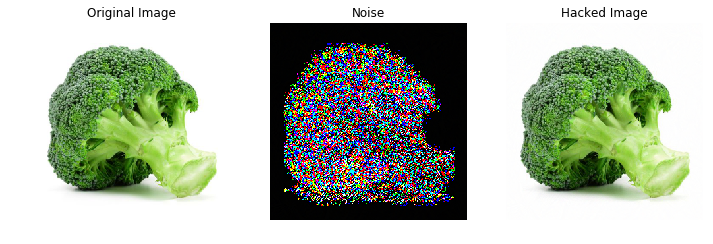

In [8]:
im = denormalise(im.reshape(im.shape[1], im.shape[2], im.shape[3]))
adv = denormalise(adv.reshape(adv.shape[1], adv.shape[2], adv.shape[3]))
plot_images_noise(im, adv)

## Save the Adv Image

In [9]:
# It would be recommended to point the NN hacked
matplotlib.image.imsave('hacked_broccoli_inception.png', adv)

## Save GIF Attack

In [17]:
images_den = []
for i, image in enumerate(images):
    if i% 100 == 0:
        images_den.append(image.reshape(image.shape[1], image.shape[2], image.shape[3]))
imageio.mimsave('broccoli_attack.gif', images_den)

## Try again

In [10]:
decode_predictions(nn.predict(preprocess_input(adv.reshape(1, adv.shape[0], adv.shape[1], adv.shape[2]))))

[[('n07873807', 'pizza', 0.9995776),
  ('n02776631', 'bakery', 2.8861803e-05),
  ('n07860988', 'dough', 2.8750379e-05),
  ('n07693725', 'bagel', 1.9761126e-05),
  ('n07880968', 'burrito', 1.7780867e-05)]]